# K-nearest neighbor for classification

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import utils


  _________________________________
| Feed me some grass! Ik heb honger |
                                 \
                                  \
                                    ^__^
                                    (oo)\_______
                                    (__)\       )\/\
                                        ||----w |
                                        ||     ||


In [2]:
from sklearn import neighbors, datasets, preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

###### Load Data


In [3]:
### Naming explanation:
# punchtype_subject No._run_number_datatype
# cross_01_01_Gyroscope: Gyroscope data of the 1st Subject collected in 1st run

dirpath_experimental_data = "Data/Raw Data/Experimental"
dict_exp_data = dict()


# Walk through each folder in Experimental Data Folder 
for foldername in os.listdir(dirpath_experimental_data):
    
    # punch_name = "_".join(foldername.split("_")[:2])

    # Walk through each file in each folder. Fetch and load the Linear Acceleration data and Gyroscope data
    for filename in os.listdir(os.path.join(dirpath_experimental_data,foldername)):
        
        if any([filename.startswith("Gyroscope"), filename.startswith("Linear")]):

            data_name = str(foldername) + "_" + str(filename)
            
            # Modify the file name to make the format consistent
            data_name = "_".join(data_name.replace(".csv","").replace("Accelerometer", "Acceleration").replace("sub-", "").replace("run-","").split("_"))

            # Assign each csv as a DataFrame to a dictionary
            data_content = pd.read_csv(os.path.join(dirpath_experimental_data, foldername, filename))
            dict_exp_data.setdefault(data_name, data_content)

print(dict_exp_data.keys())

dict_keys(['cross_01_01_Gyroscope', 'cross_01_01_Linear Acceleration', 'cross_02_01_Gyroscope', 'cross_02_01_Linear Acceleration', 'cross_03_01_Gyroscope', 'cross_03_01_Linear Acceleration', 'jab_01_01_Gyroscope', 'jab_01_01_Linear Acceleration', 'jab_02_01_Gyroscope', 'jab_02_01_Linear Acceleration', 'jab_03_01_Gyroscope', 'jab_03_01_Linear Acceleration', 'lefthook_01_01_Gyroscope', 'lefthook_01_01_Linear Acceleration', 'lefthook_02_01_Gyroscope', 'lefthook_02_01_Linear Acceleration', 'lefthook_03_01_Gyroscope', 'lefthook_03_01_Linear Acceleration', 'leftnopunch_01_01_Gyroscope', 'leftnopunch_01_01_Linear Acceleration', 'leftnopunch_02_01_Gyroscope', 'leftnopunch_02_01_Linear Acceleration', 'leftnopunch_03_01_Gyroscope', 'leftnopunch_03_01_Linear Acceleration', 'leftuppercut_02_01_Gyroscope', 'leftuppercut_02_01_Linear Acceleration', 'leftuppercut_03_01_Gyroscope', 'leftuppercut_03_01_Linear Acceleration', 'leftupper_01_01_Gyroscope', 'leftupper_01_01_Linear Acceleration', 'righthook_

In [4]:
# Changing colnames for consistency

acc_columns = {"Linear Acceleration x (m/s^2)" : "X (m/s^2)",
               "Linear Acceleration y (m/s^2)" : "Y (m/s^2)",
               "Linear Acceleration z (m/s^2)" : "Z (m/s^2)"
               }

gyr_columns = {"Gyroscope x (rad/s)" : "X (rad/s)",
               "Gyroscope y (rad/s)" : "Y (rad/s)",
               "Gyroscope z (rad/s)" : "Z (rad/s)"
               }

for df_name, df_content in dict_exp_data.items():
    
    if df_name.endswith("Linear Acceleration"):
        df_content.rename(columns=acc_columns, inplace=True)

    elif df_name.endswith("Gyroscope"):
        df_content.rename(columns=gyr_columns, inplace=True)

In [5]:
for df in dict_exp_data.keys():
    print(df)

cross_01_01_Gyroscope
cross_01_01_Linear Acceleration
cross_02_01_Gyroscope
cross_02_01_Linear Acceleration
cross_03_01_Gyroscope
cross_03_01_Linear Acceleration
jab_01_01_Gyroscope
jab_01_01_Linear Acceleration
jab_02_01_Gyroscope
jab_02_01_Linear Acceleration
jab_03_01_Gyroscope
jab_03_01_Linear Acceleration
lefthook_01_01_Gyroscope
lefthook_01_01_Linear Acceleration
lefthook_02_01_Gyroscope
lefthook_02_01_Linear Acceleration
lefthook_03_01_Gyroscope
lefthook_03_01_Linear Acceleration
leftnopunch_01_01_Gyroscope
leftnopunch_01_01_Linear Acceleration
leftnopunch_02_01_Gyroscope
leftnopunch_02_01_Linear Acceleration
leftnopunch_03_01_Gyroscope
leftnopunch_03_01_Linear Acceleration
leftuppercut_02_01_Gyroscope
leftuppercut_02_01_Linear Acceleration
leftuppercut_03_01_Gyroscope
leftuppercut_03_01_Linear Acceleration
leftupper_01_01_Gyroscope
leftupper_01_01_Linear Acceleration
righthook_01_01_Gyroscope
righthook_01_01_Linear Acceleration
righthook_02_01_Gyroscope
righthook_02_01_Linear A

## 1. Data Transformation

In [6]:
# Concatenate data: First we concatenate them vertically (by same metrics), then we concatinate them horizontally (by same type of punch)

punch_types = ['leftnopunch', 'rightnopunch','jab','cross', 'lefthook', 'righthook', 'leftuppercut','rightuppercut']


def concat_df(dict_original_data, concat_step, axis):

    result_dict = dict()

    i = 0
    j = concat_step
    
    while i < len(dict_original_data):
        concat_df_name = [key for key in dict_original_data.keys()][i]
        concat_df_content = [val for val in dict_original_data.values()][i:j]
        result_dict.setdefault(concat_df_name, pd.concat(concat_df_content, axis=axis))
    
        i += concat_step
        j += concat_step
    
    return result_dict

def simplify_df_names(dict_df, list_new_names):

    dict_with_new_dfname = dict()

    for old_name, df_content in dict_df.items():

        for new_name in list_new_names:

            if any([new_name in old_name, old_name.startswith(new_name)]):
                dict_with_new_dfname.setdefault(new_name, df_content)

    return dict_with_new_dfname

dict_df_concated = concat_df(dict_exp_data, 2, 1)

dict_df_concated_final = simplify_df_names(concat_df(dict_df_concated, 3, 0), punch_types)

In [7]:
# Label the data

# Forward fill the missing value

def dataframe_labeller(df,label):
    df["Punch Type"] = label

for df, label in list(zip([df_content for df_content in dict_df_concated_final.values()],sorted(punch_types))):
    dataframe_labeller(df, label)
    df.ffill()

for punch_type, df_content in dict_df_concated_final.items():
    print(punch_type, ":")
    print(df_content)

cross :
         Time (s)  X (rad/s)  Y (rad/s)  Z (rad/s)    Time (s)  X (m/s^2)  \
0        0.065232   0.240676  -0.045339   0.668833    0.065232   1.683050   
1        0.085103   0.451193   0.059653   0.542470    0.085103   1.408963   
2        0.105020   0.605252   0.159319   0.360182    0.105020   0.555544   
3        0.124894   0.701722   0.136949   0.213113    0.124894  -0.377898   
4        0.144788   0.704385   0.005792   0.125697    0.144788  -0.791464   
...           ...        ...        ...        ...         ...        ...   
14995  299.926293  -0.307508   2.953404  -2.347397  299.926293  -0.143904   
14996  299.946296  -0.500159   3.585149  -1.779337  299.946296   0.225561   
14997  299.966297  -0.560263   4.260557  -1.421962  299.966297  -0.275865   
14998  299.986298  -0.623602   4.781751  -1.339635  299.986298  -1.019574   
14999  300.006300  -0.804991   5.138650  -1.371697  300.006300  -1.558969   

       Y (m/s^2)  Z (m/s^2) Punch Type  
0      -1.668346  -1.43239

In [8]:
# View the raw info of transformed data

for punch_type, df_content in dict_df_concated_final.items():
    print(punch_type, ":")
    print(df_content.describe())

cross :
           Time (s)     X (rad/s)     Y (rad/s)     Z (rad/s)      Time (s)  \
count  52752.000000  52752.000000  52752.000000  52752.000000  52751.000000   
mean     182.370743      0.010967      0.063197     -0.026782    182.368512   
std      113.776164      1.692620      3.565020      3.169228    113.776089   
min        0.000183    -16.179197    -34.887180    -24.224096      0.000183   
25%       87.560418     -0.442109     -0.597692     -0.486286     87.558405   
50%      175.099950     -0.004498     -0.000909     -0.000720    175.098877   
75%      262.839930      0.495264      1.143176      0.674835    262.831805   
max      450.566186     16.443207     27.484556     25.414774    450.566186   

          X (m/s^2)     Y (m/s^2)     Z (m/s^2)  
count  52751.000000  52751.000000  52751.000000  
mean       0.498109     -1.145481     -0.665079  
std       11.058316     13.689176      7.272231  
min      -80.683165   -115.448820   -123.536062  
25%       -1.179261     -2.262

In [9]:
# Remove outliers

# Before that, we drop time and return a new dict of df

def remove_outliers(df):

    # Remove the label from the original df because string is not used for statistics
    df_no_outliers = df.iloc[:,:-1].copy()
    df_label = df["Punch Type"].unique()

    accelerometer_feature = "(m/s^2)"

    for feature in df_no_outliers.columns:
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) of each feature
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define outlier criteria
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers, but treat Acceleration and other features differently (see report for details)
        if accelerometer_feature in feature:
            df_no_outliers = df_no_outliers[~((df_no_outliers[feature] < lower_bound))]
            
        else:
            df_no_outliers = df_no_outliers[~((df_no_outliers[feature] < lower_bound) | (df_no_outliers[feature] > upper_bound))]

    # Assign the label back
    df_no_outliers["Punch Type"] = df_label[0]

    return df_no_outliers


In [10]:
# # Remove outliers on raw data causes too many information loss. 
# # We remove outliers after the aggregation

# dict_df_concated_final_clean = dict()

# for punch_type, df_content in dict_df_concated_final.items():

#     dict_df_concated_final_clean.setdefault(punch_type, remove_outliers(df_content.drop(columns="Time (s)")))

# for punch_type, df_content in dict_df_concated_final_clean.items():

#     print(punch_type, ":")
#     print(df_content)

In [11]:
def boxplot_feature(df, punch_type, figsize = (10,10), show_dist = False, savefig=False):

    """
    Make Boxplot of each feature within a same type of punch.
    If show_dist = True, then it will plot a violinplot instead. 
    """

    df_copy = df.copy()
    
    if show_dist:
        
        plt.figure(figsize=figsize) 
        plt.ylim(0,20)
        sns.violinplot(df_copy)
        plt.title(f"Violinplot of features in {punch_type}")
    
        if savefig:
            plt.savefig(f"Figures\\violin_{punch_type}.png")

    else:
        plt.figure(figsize=figsize)    
        plt.ylim(0,20)
        sns.boxplot(df_copy)
        plt.title(f"Boxplot of features in {punch_type}")
    
        if savefig:
            plt.savefig(f"Figures\\Boxplot_{punch_type}.png")
        
    plt.show()

# def make_violinplot_punchtype(feature, figsize = (10,10), savefig=False):
#     df_joined = pd.concat([df for df in dict_transformed_data.values()],axis=0)

#     plt.figure(figsize=figsize)
#     df_melted = df_joined.melt(id_vars='Punch Type', value_vars=[feature], var_name='Feature', value_name='Value')
    
#     plt.figure(figsize=figsize)
#     sns.violinplot(data=df_melted, x='Feature', y='Value', hue='Punch Type', split=True)
#     plt.title(f"Violinplot of {feature} across classes")
    
#     if savefig:
#         plt.savefig(f"violinplot_{feature}.png")
    
#     plt.show()


In [12]:
# Remove time from the data
dict_df_concated_NoTime = dict()

for punch_type, df_content in dict_df_concated_final.items():

    dict_df_concated_NoTime.setdefault(punch_type, df_content.drop(columns="Time (s)"))

dict_df_concated_NoTime

{'cross':        X (rad/s)  Y (rad/s)  Z (rad/s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)  \
 0       0.240676  -0.045339   0.668833   1.683050  -1.668346  -1.432390   
 1       0.451193   0.059653   0.542470   1.408963  -0.833281  -1.033995   
 2       0.605252   0.159319   0.360182   0.555544   0.084102  -0.627524   
 3       0.701722   0.136949   0.213113  -0.377898   1.033287  -0.123379   
 4       0.704385   0.005792   0.125697  -0.791464   1.543793   0.366435   
 ...          ...        ...        ...        ...        ...        ...   
 14995  -0.307508   2.953404  -2.347397  -0.143904   1.580076   1.579204   
 14996  -0.500159   3.585149  -1.779337   0.225561   0.673862  -0.569482   
 14997  -0.560263   4.260557  -1.421962  -0.275865   0.650340  -0.795494   
 14998  -0.623602   4.781751  -1.339635  -1.019574   1.862951  -0.137417   
 14999  -0.804991   5.138650  -1.371697  -1.558969   2.324484  -1.287985   
 
       Punch Type  
 0          cross  
 1          cross  
 2          cross

In [13]:
### Create 2 versions of aggregated data with window size of 50 and 100. Both of them are groupped by mean absolute value

print(help(utils.aggregate_data))

dict_df_transformed_50 = dict()
dict_df_transformed_100 = dict()

for punch_type, df_content in dict_df_concated_NoTime.items():
    dict_df_transformed_50.setdefault(punch_type, utils.aggregate_data(df_content, 50, punch_type))
    dict_df_transformed_100.setdefault(punch_type, utils.aggregate_data(df_content, 100, punch_type))

Help on function aggregate_data in module utils:

aggregate_data(df, window, label=None)
    Returns an aggregated dataframe on a given window size by the mean absolut value of each window.
    
        Discards the remainders that have less datapoints than the window size. Usually the 'tail' of the dataframe.
        Does not take the influence of time series into account. Usually applied for data preprocessing
            for a classical ML algorithm.
    
    :param df: The Raw, Unprocessed Data (collected by Phyphox or other device)
    :param int window: The window size of data aggregation.
    :(Optional) param str label: A label to assign to the aggregated data. None by default.
        If None, unlabelled dataframe will be returned.
    
    :returns df_agg: A dataframe with features aggregated by the mean absolut value of each window.

None


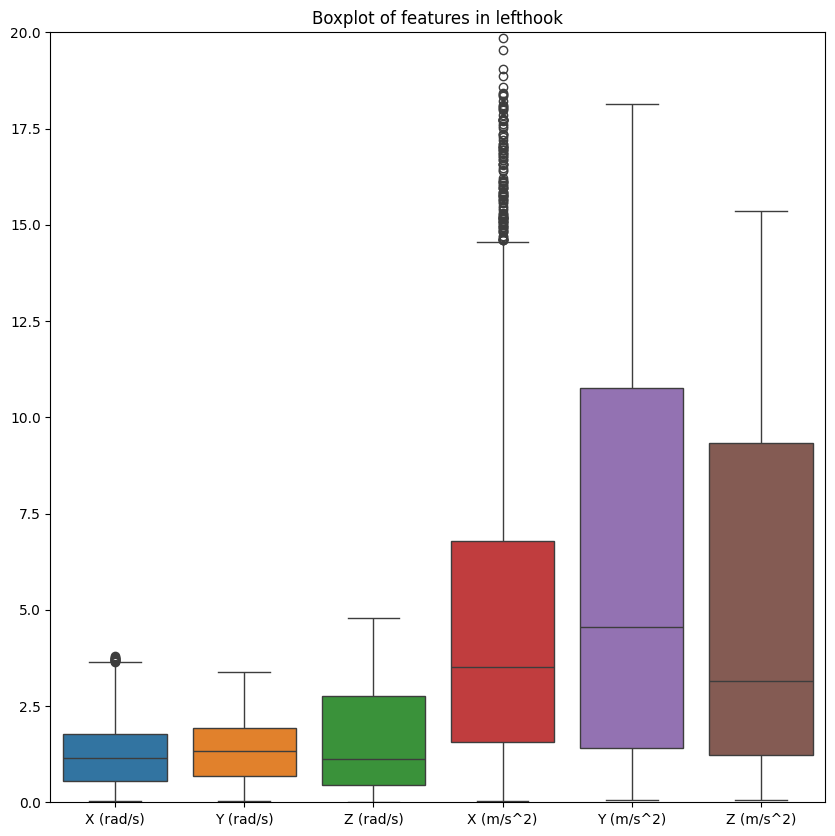

In [57]:
# boxplot_feature(dict_df_transformed_50['lefthook'],'lefthook', savefig=True)
boxplot_feature(dict_transformed_50_clean['lefthook'],'lefthook', savefig=True)

###### Check if there are missing values and outliers
Result shows that there is no missing values

In [15]:
dict_df_transformed_50

{'cross':       X (rad/s)  Y (rad/s)  Z (rad/s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)  \
 0         0.735      1.273      1.368      2.240      5.165      2.116   
 1         0.505      1.745      1.493      1.885      4.227      1.047   
 2         0.819      3.405      2.729      3.087      8.234      3.453   
 3         0.396      0.821      0.547      1.065      2.050      0.845   
 4         0.965      2.742      2.964      3.477      8.687      2.570   
 ...         ...        ...        ...        ...        ...        ...   
 1050      1.062      4.363      2.860      5.355      5.548      4.007   
 1051      0.075      0.123      0.072      0.151      0.112      0.282   
 1052      0.971      3.244      1.663      5.719      5.285      3.421   
 1053      0.252      1.793      0.752      0.420      0.322      0.804   
 1054      1.006      3.390      2.105      4.286      6.354      4.176   
 
      Punch Type  
 0         cross  
 1         cross  
 2         cross  
 3         cr

In [16]:
dict_df_transformed_100

{'cross':      X (rad/s)  Y (rad/s)  Z (rad/s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)  \
 0        0.620      1.509      1.430      2.063      4.696      1.581   
 1        0.607      2.113      1.638      2.076      5.142      2.149   
 2        0.607      1.465      1.597      2.177      4.753      1.483   
 3        0.557      1.708      1.671      1.977      4.359      1.762   
 4        0.621      2.027      1.751      1.654      3.887      2.126   
 ..         ...        ...        ...        ...        ...        ...   
 522      0.530      2.558      1.334      2.515      2.654      1.892   
 523      0.682      1.841      1.335      2.666      3.191      2.132   
 524      0.164      0.692      0.404      0.486      0.320      0.619   
 525      0.568      2.243      1.466      2.753      2.830      2.145   
 526      0.612      2.519      1.208      3.070      2.803      2.112   
 
     Punch Type  
 0        cross  
 1        cross  
 2        cross  
 3        cross  
 4        c

Missing Value and outlier check for data with window size of 50:
cross :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   1055 non-null   float64
 1   Y (rad/s)   1055 non-null   float64
 2   Z (rad/s)   1055 non-null   float64
 3   X (m/s^2)   1055 non-null   float64
 4   Y (m/s^2)   1055 non-null   float64
 5   Z (m/s^2)   1055 non-null   float64
 6   Punch Type  1055 non-null   object 
dtypes: float64(6), object(1)
memory usage: 57.8+ KB
None


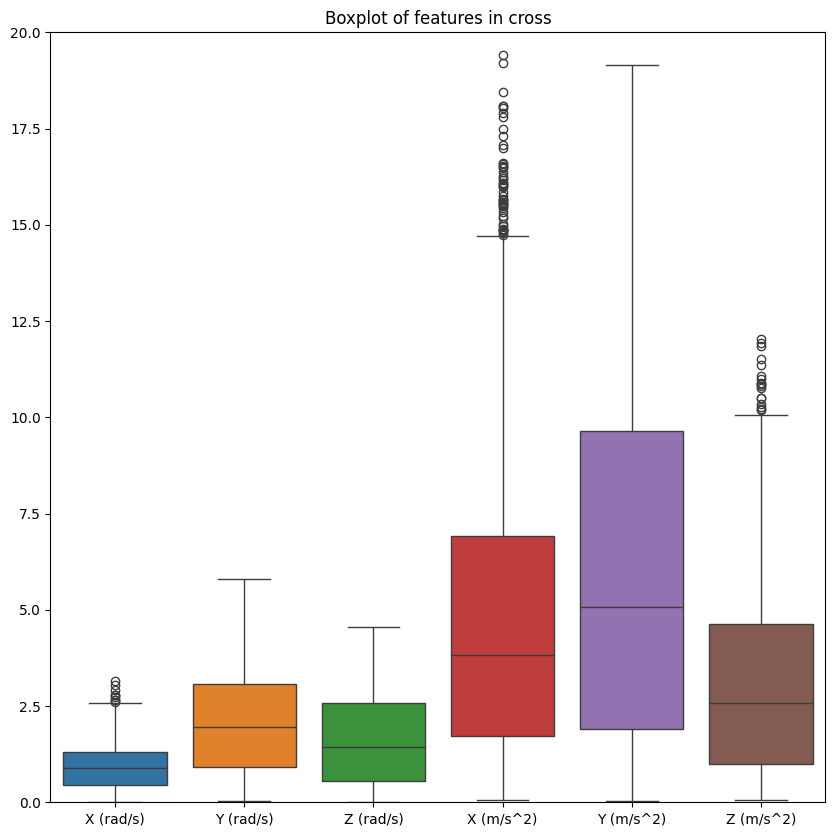

jab :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   1100 non-null   float64
 1   Y (rad/s)   1100 non-null   float64
 2   Z (rad/s)   1100 non-null   float64
 3   X (m/s^2)   1100 non-null   float64
 4   Y (m/s^2)   1100 non-null   float64
 5   Z (m/s^2)   1100 non-null   float64
 6   Punch Type  1100 non-null   object 
dtypes: float64(6), object(1)
memory usage: 60.3+ KB
None


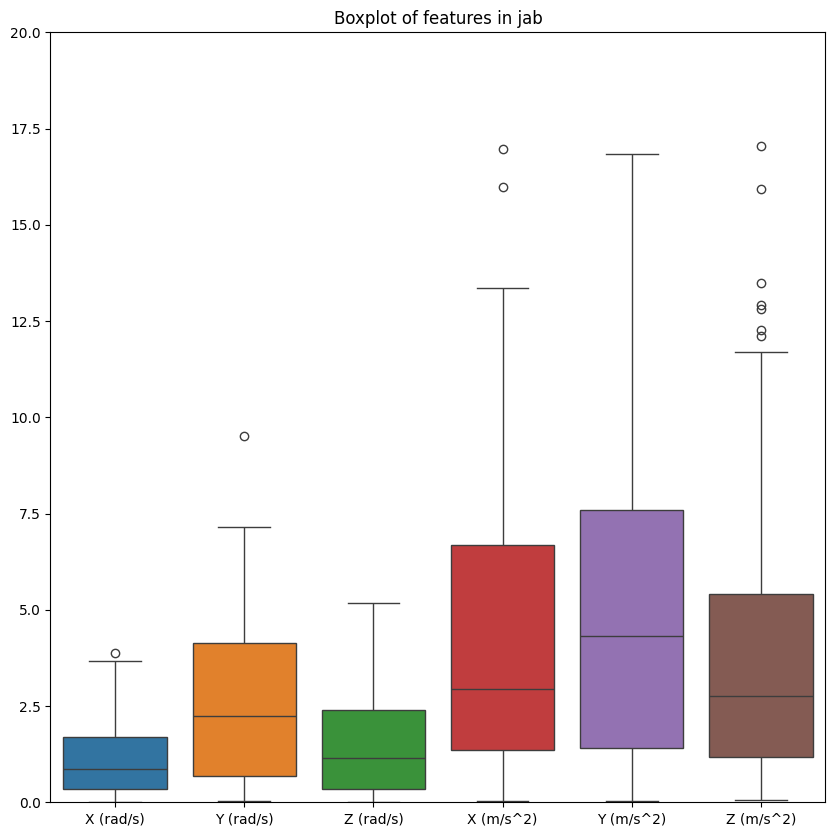

lefthook :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   1029 non-null   float64
 1   Y (rad/s)   1029 non-null   float64
 2   Z (rad/s)   1029 non-null   float64
 3   X (m/s^2)   1029 non-null   float64
 4   Y (m/s^2)   1029 non-null   float64
 5   Z (m/s^2)   1029 non-null   float64
 6   Punch Type  1029 non-null   object 
dtypes: float64(6), object(1)
memory usage: 56.4+ KB
None


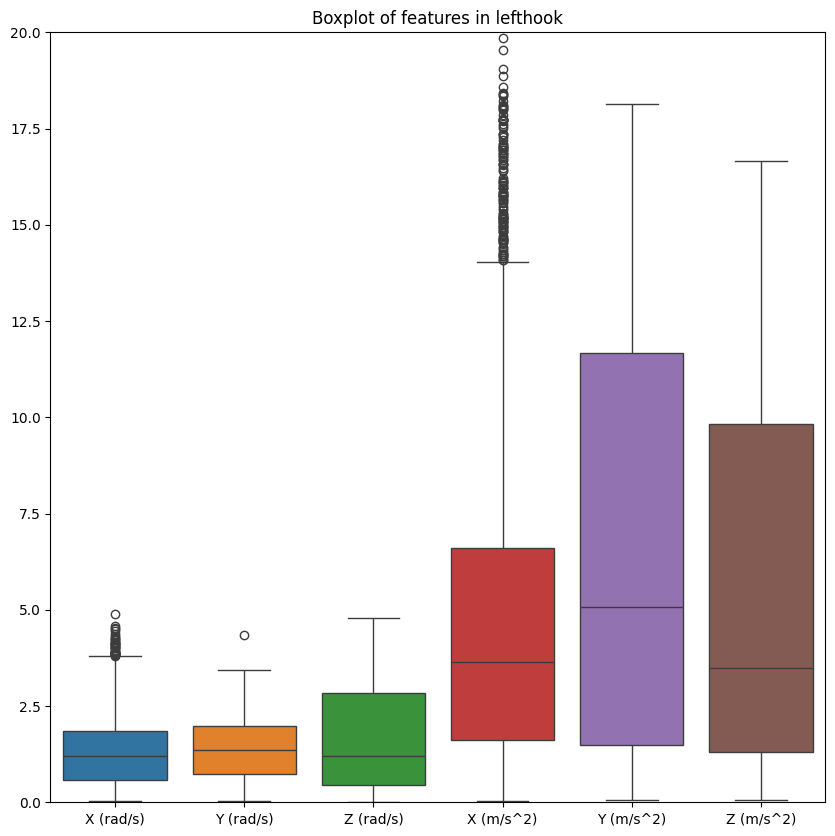

leftnopunch :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   903 non-null    float64
 1   Y (rad/s)   903 non-null    float64
 2   Z (rad/s)   903 non-null    float64
 3   X (m/s^2)   903 non-null    float64
 4   Y (m/s^2)   903 non-null    float64
 5   Z (m/s^2)   903 non-null    float64
 6   Punch Type  903 non-null    object 
dtypes: float64(6), object(1)
memory usage: 49.5+ KB
None


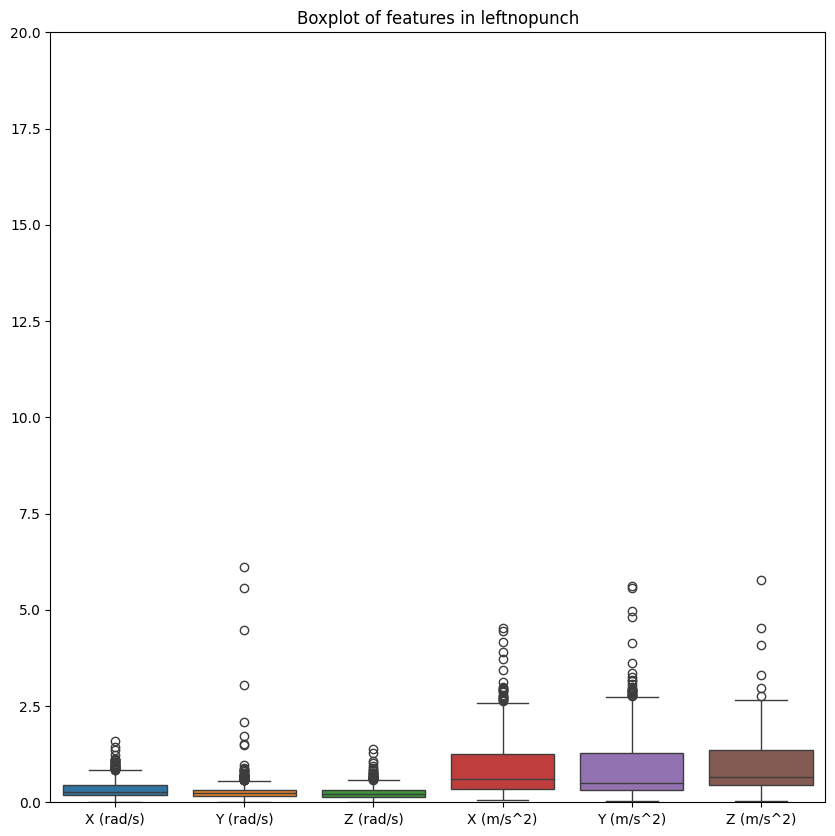

leftuppercut :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   903 non-null    float64
 1   Y (rad/s)   903 non-null    float64
 2   Z (rad/s)   903 non-null    float64
 3   X (m/s^2)   903 non-null    float64
 4   Y (m/s^2)   903 non-null    float64
 5   Z (m/s^2)   903 non-null    float64
 6   Punch Type  903 non-null    object 
dtypes: float64(6), object(1)
memory usage: 49.5+ KB
None


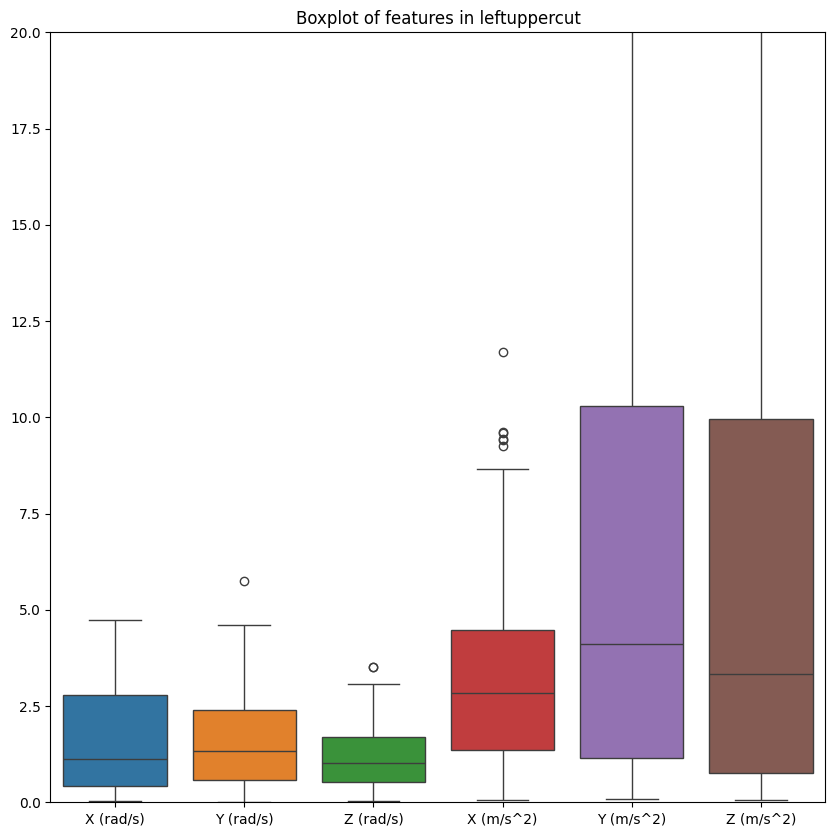

righthook :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   903 non-null    float64
 1   Y (rad/s)   903 non-null    float64
 2   Z (rad/s)   903 non-null    float64
 3   X (m/s^2)   903 non-null    float64
 4   Y (m/s^2)   903 non-null    float64
 5   Z (m/s^2)   903 non-null    float64
 6   Punch Type  903 non-null    object 
dtypes: float64(6), object(1)
memory usage: 49.5+ KB
None


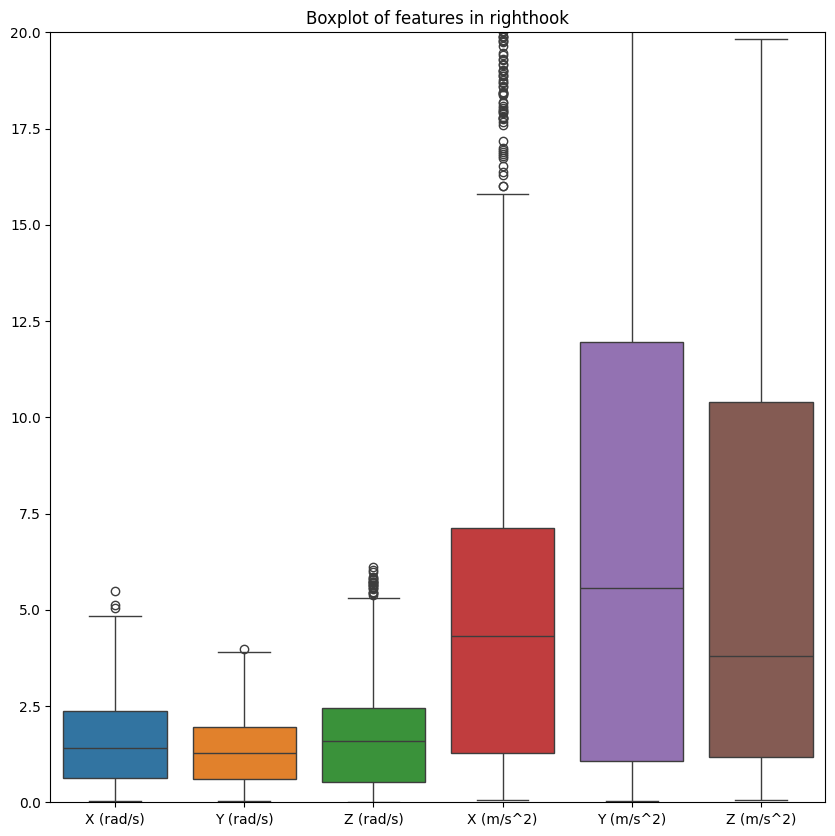

rightnopunch :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   903 non-null    float64
 1   Y (rad/s)   903 non-null    float64
 2   Z (rad/s)   903 non-null    float64
 3   X (m/s^2)   903 non-null    float64
 4   Y (m/s^2)   903 non-null    float64
 5   Z (m/s^2)   903 non-null    float64
 6   Punch Type  903 non-null    object 
dtypes: float64(6), object(1)
memory usage: 49.5+ KB
None


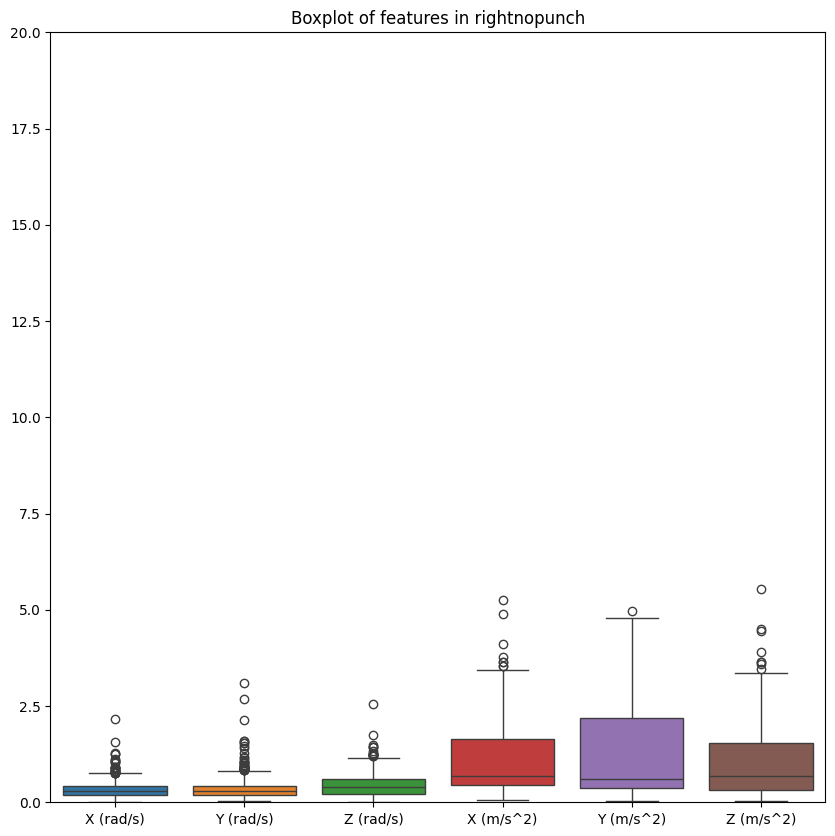

rightuppercut :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   941 non-null    float64
 1   Y (rad/s)   941 non-null    float64
 2   Z (rad/s)   941 non-null    float64
 3   X (m/s^2)   941 non-null    float64
 4   Y (m/s^2)   941 non-null    float64
 5   Z (m/s^2)   941 non-null    float64
 6   Punch Type  941 non-null    object 
dtypes: float64(6), object(1)
memory usage: 51.6+ KB
None


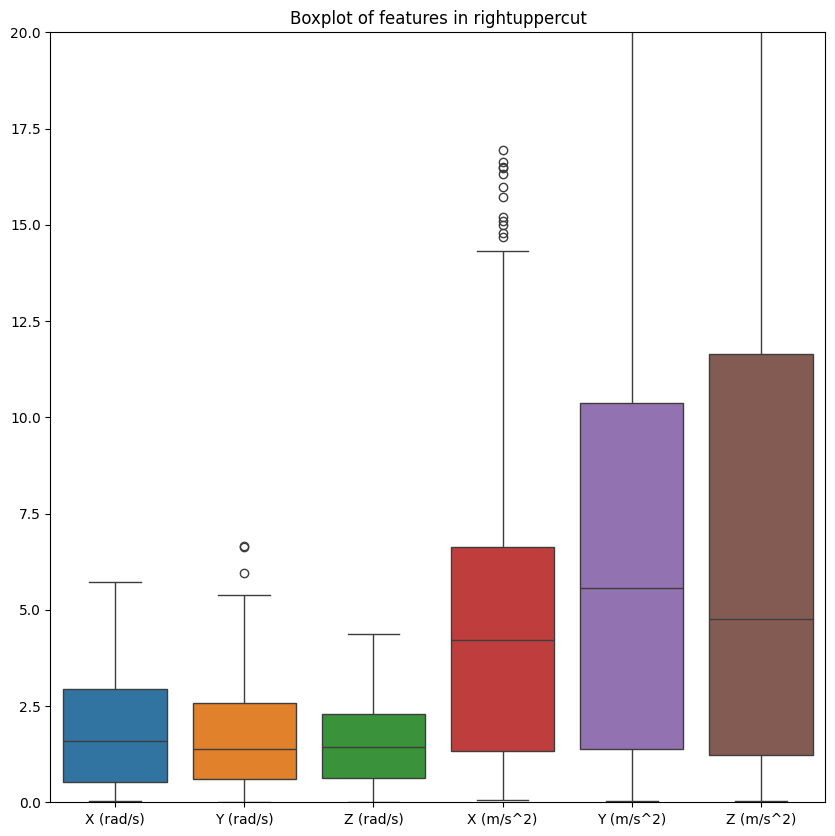

Missing Value and outlier check for data with window size of 100:
cross :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   527 non-null    float64
 1   Y (rad/s)   527 non-null    float64
 2   Z (rad/s)   527 non-null    float64
 3   X (m/s^2)   527 non-null    float64
 4   Y (m/s^2)   527 non-null    float64
 5   Z (m/s^2)   527 non-null    float64
 6   Punch Type  527 non-null    object 
dtypes: float64(6), object(1)
memory usage: 28.9+ KB
None


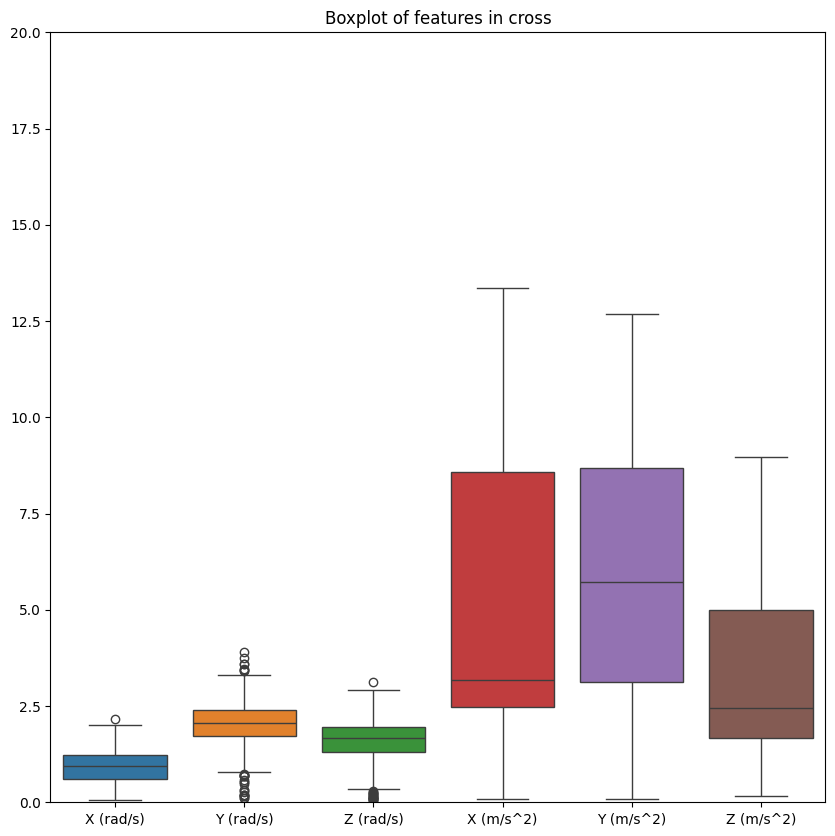

jab :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   550 non-null    float64
 1   Y (rad/s)   550 non-null    float64
 2   Z (rad/s)   550 non-null    float64
 3   X (m/s^2)   550 non-null    float64
 4   Y (m/s^2)   550 non-null    float64
 5   Z (m/s^2)   550 non-null    float64
 6   Punch Type  550 non-null    object 
dtypes: float64(6), object(1)
memory usage: 30.2+ KB
None


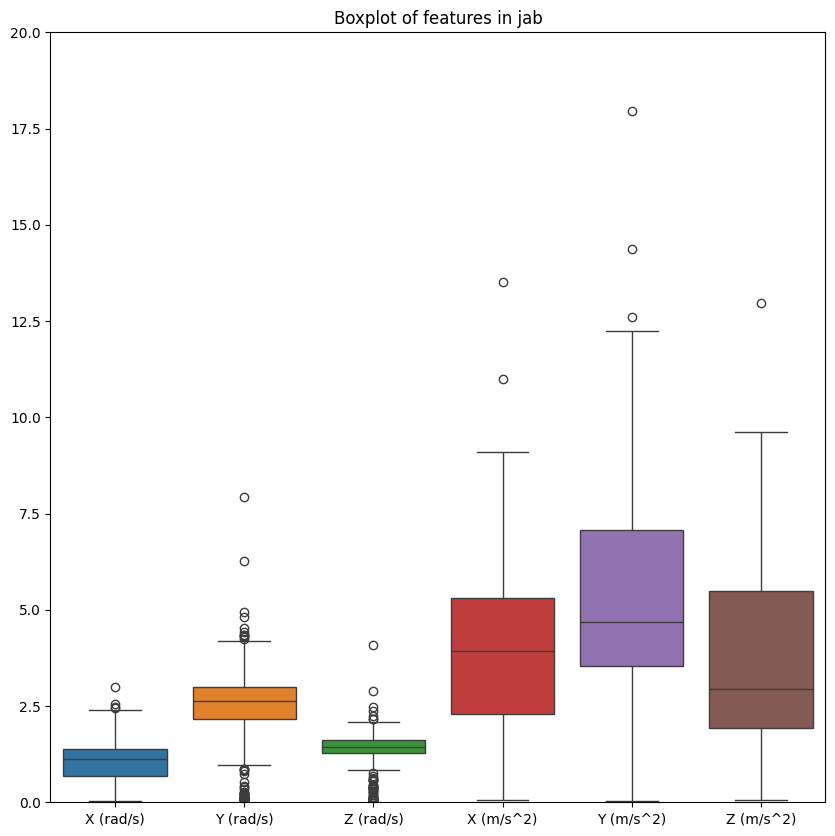

lefthook :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   514 non-null    float64
 1   Y (rad/s)   514 non-null    float64
 2   Z (rad/s)   514 non-null    float64
 3   X (m/s^2)   514 non-null    float64
 4   Y (m/s^2)   514 non-null    float64
 5   Z (m/s^2)   514 non-null    float64
 6   Punch Type  514 non-null    object 
dtypes: float64(6), object(1)
memory usage: 28.2+ KB
None


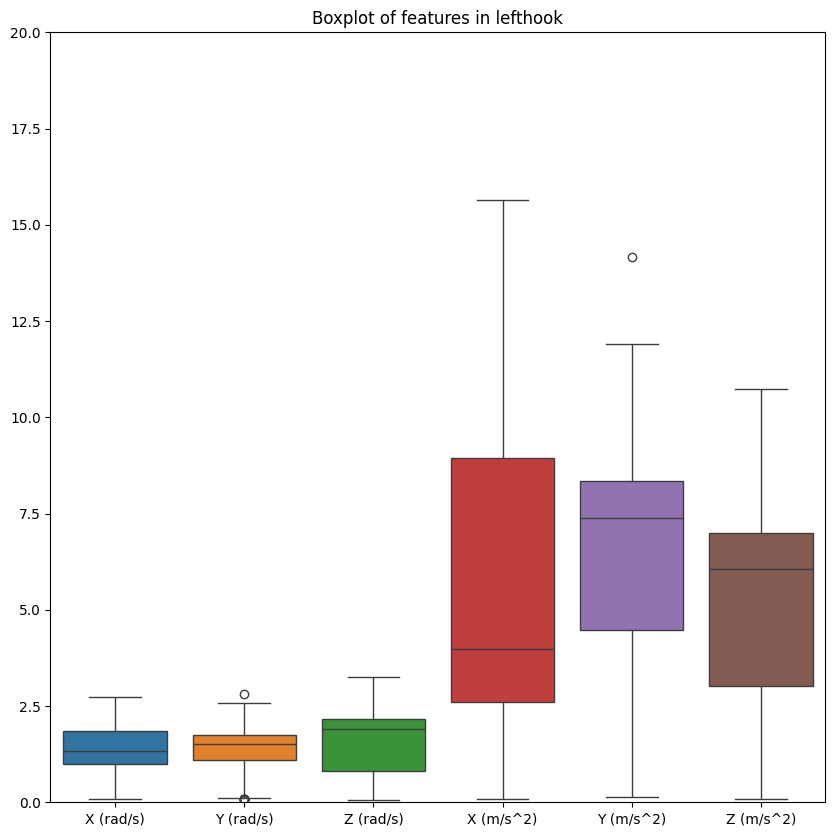

leftnopunch :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   451 non-null    float64
 1   Y (rad/s)   451 non-null    float64
 2   Z (rad/s)   451 non-null    float64
 3   X (m/s^2)   451 non-null    float64
 4   Y (m/s^2)   451 non-null    float64
 5   Z (m/s^2)   451 non-null    float64
 6   Punch Type  451 non-null    object 
dtypes: float64(6), object(1)
memory usage: 24.8+ KB
None


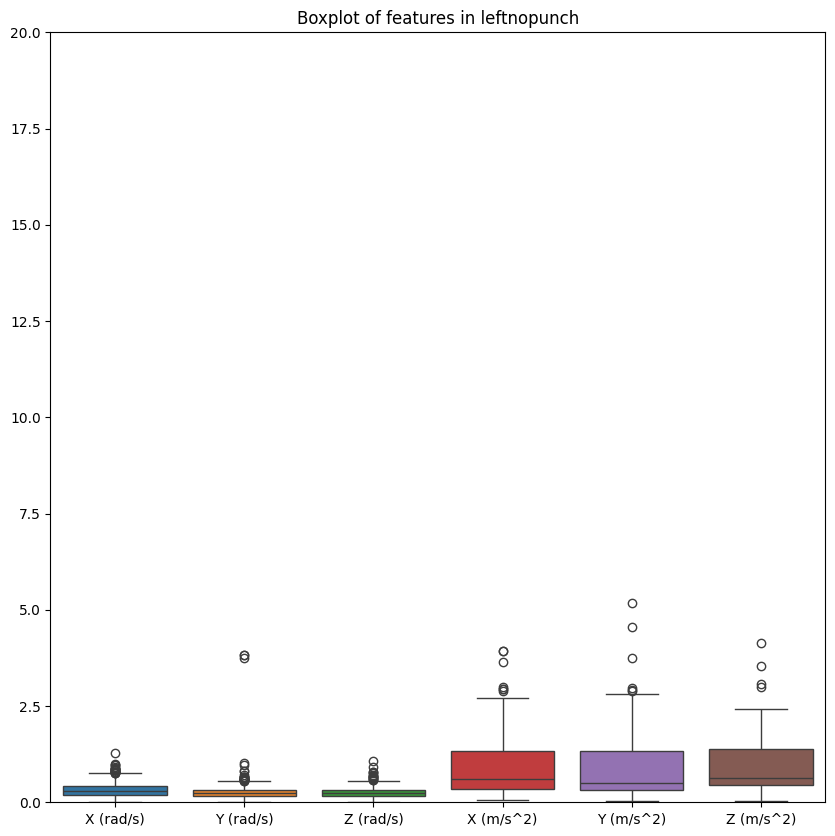

leftuppercut :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   451 non-null    float64
 1   Y (rad/s)   451 non-null    float64
 2   Z (rad/s)   451 non-null    float64
 3   X (m/s^2)   451 non-null    float64
 4   Y (m/s^2)   451 non-null    float64
 5   Z (m/s^2)   451 non-null    float64
 6   Punch Type  451 non-null    object 
dtypes: float64(6), object(1)
memory usage: 24.8+ KB
None


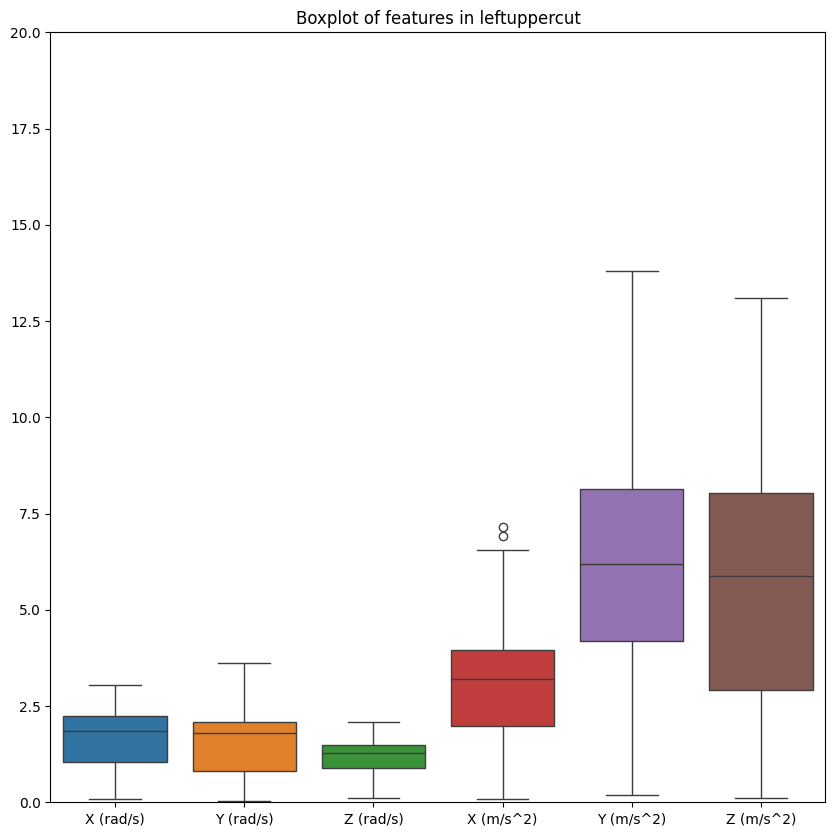

righthook :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   451 non-null    float64
 1   Y (rad/s)   451 non-null    float64
 2   Z (rad/s)   451 non-null    float64
 3   X (m/s^2)   451 non-null    float64
 4   Y (m/s^2)   451 non-null    float64
 5   Z (m/s^2)   451 non-null    float64
 6   Punch Type  451 non-null    object 
dtypes: float64(6), object(1)
memory usage: 24.8+ KB
None


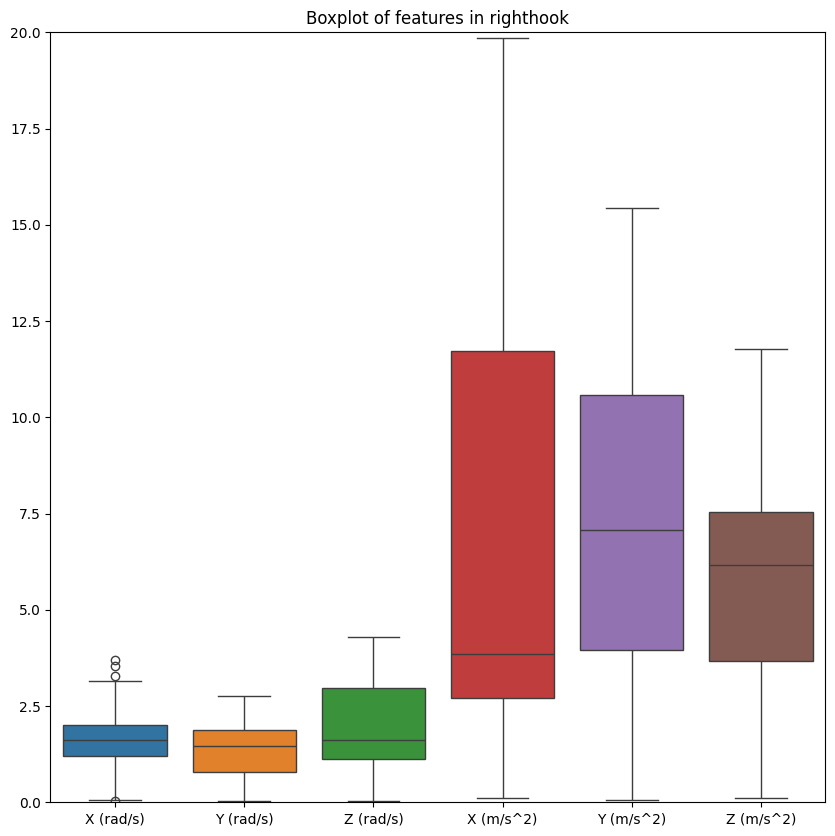

rightnopunch :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   451 non-null    float64
 1   Y (rad/s)   451 non-null    float64
 2   Z (rad/s)   451 non-null    float64
 3   X (m/s^2)   451 non-null    float64
 4   Y (m/s^2)   451 non-null    float64
 5   Z (m/s^2)   451 non-null    float64
 6   Punch Type  451 non-null    object 
dtypes: float64(6), object(1)
memory usage: 24.8+ KB
None


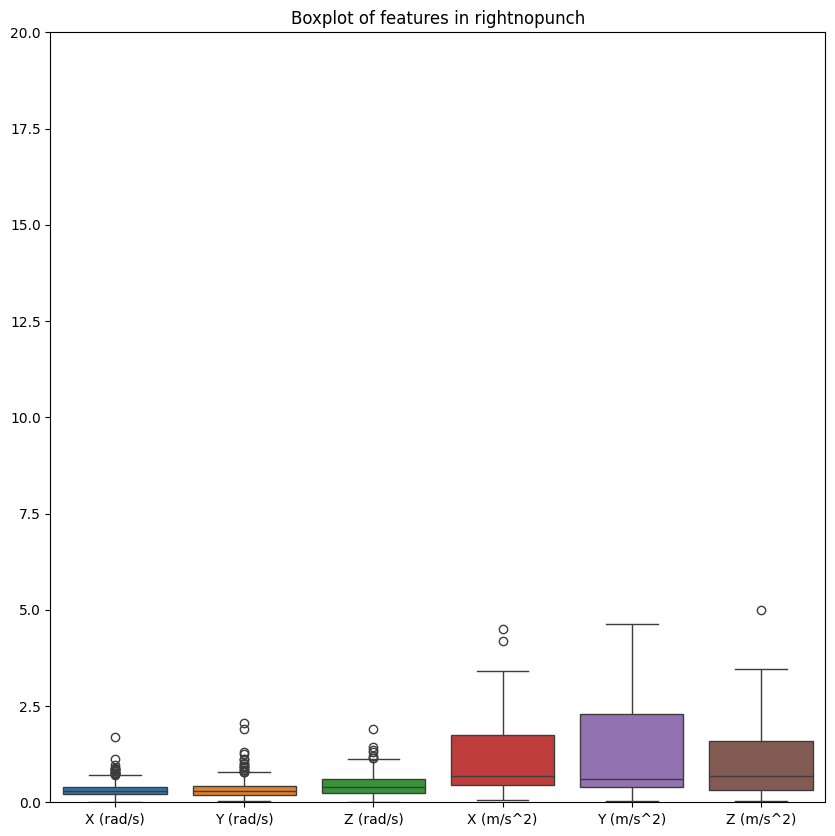

rightuppercut :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X (rad/s)   470 non-null    float64
 1   Y (rad/s)   470 non-null    float64
 2   Z (rad/s)   470 non-null    float64
 3   X (m/s^2)   470 non-null    float64
 4   Y (m/s^2)   470 non-null    float64
 5   Z (m/s^2)   470 non-null    float64
 6   Punch Type  470 non-null    object 
dtypes: float64(6), object(1)
memory usage: 25.8+ KB
None


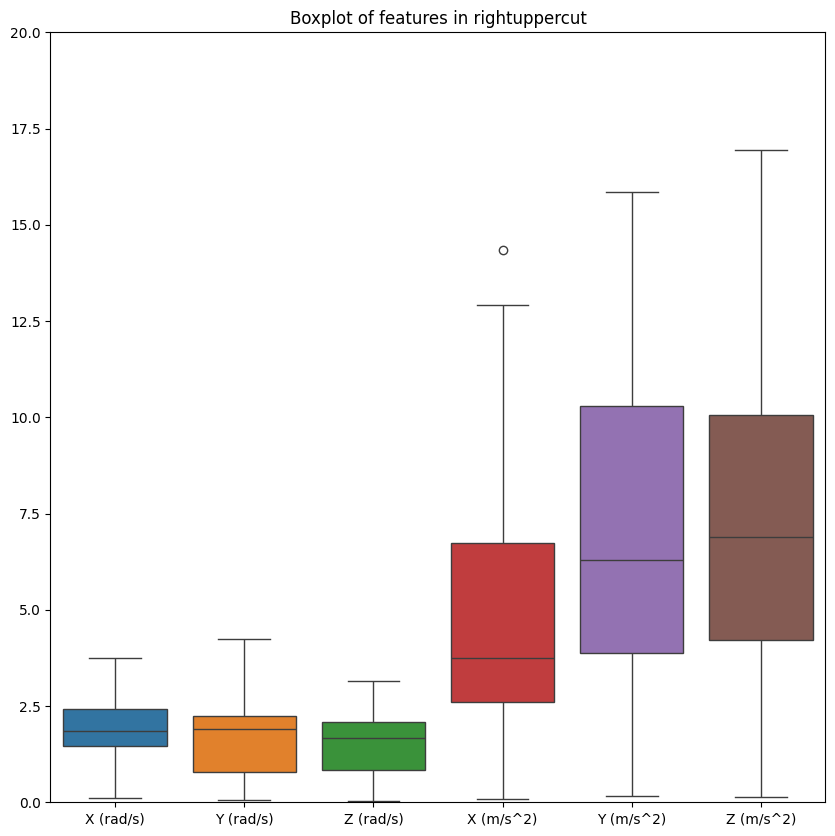

In [17]:
print("Missing Value and outlier check for data with window size of 50:")

for df_name, df_content in dict_df_transformed_50.items():
    print(df_name, ":")
    print(df_content.info())
    boxplot_feature(df_content, df_name)

print("Missing Value and outlier check for data with window size of 100:")
for df_name, df_content in dict_df_transformed_100.items():
    print(df_name, ":")
    print(df_content.info())
    boxplot_feature(df_content, df_name)

In [18]:
# Remove outliers
dict_transformed_50_clean = dict()
dict_transformed_100_clean = dict()

for df_name, df_content in dict_df_transformed_50.items():
    dict_transformed_50_clean.setdefault(df_name, remove_outliers(df_content))

for df_name, df_content in dict_df_transformed_100.items():
    dict_transformed_100_clean.setdefault(df_name, remove_outliers(df_content))

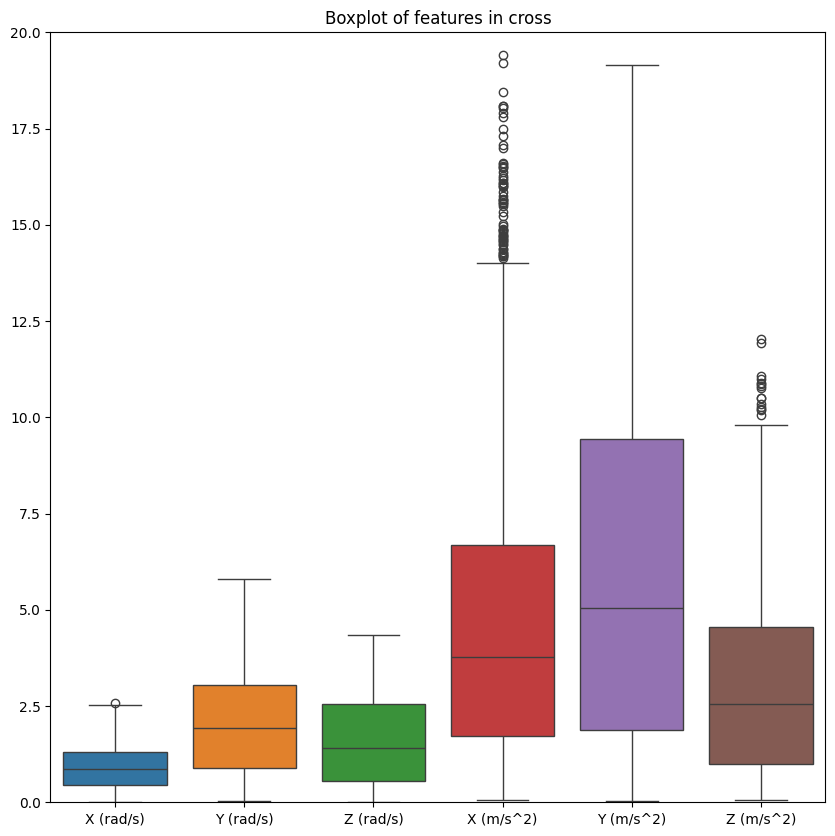

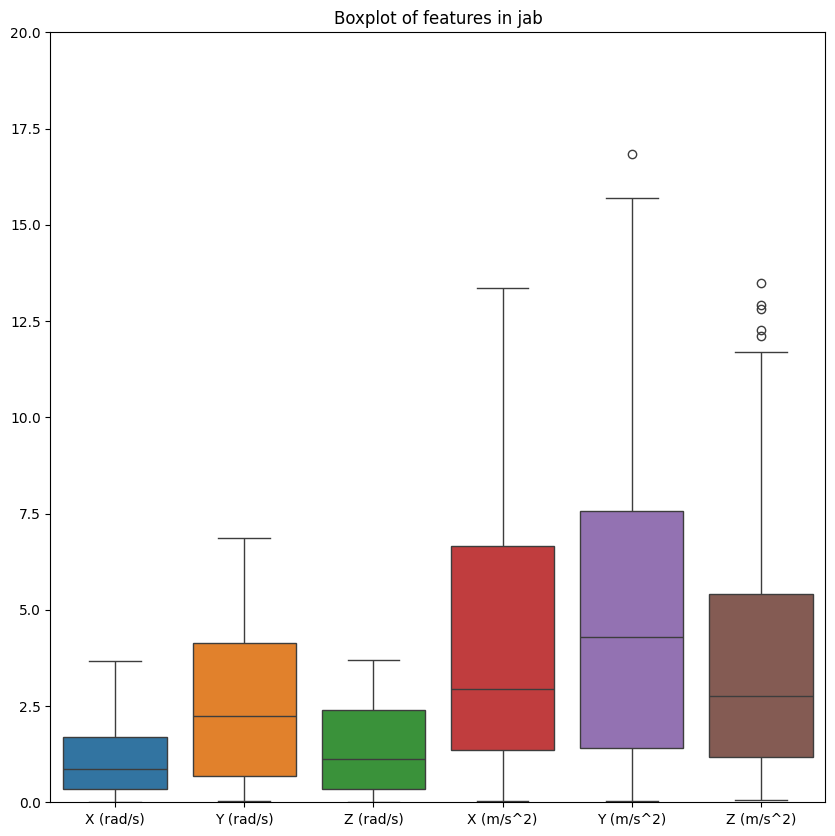

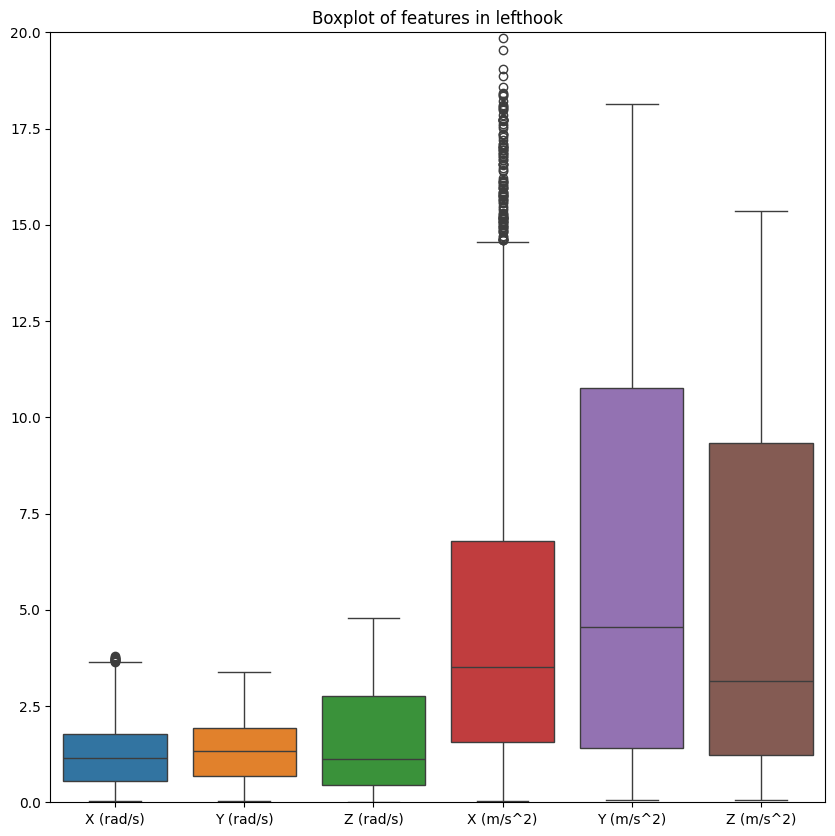

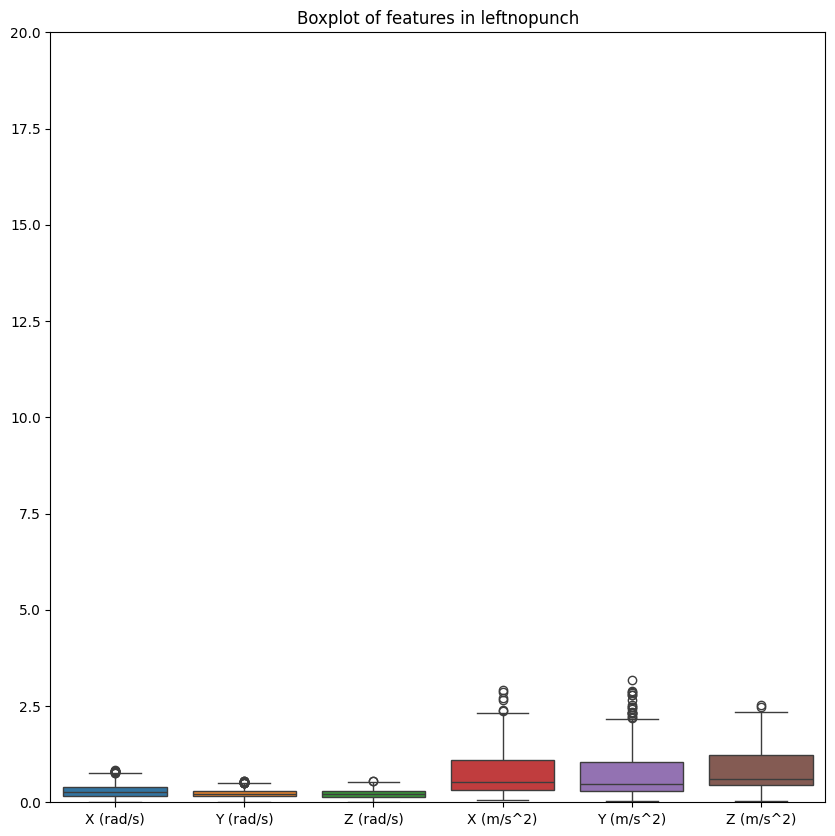

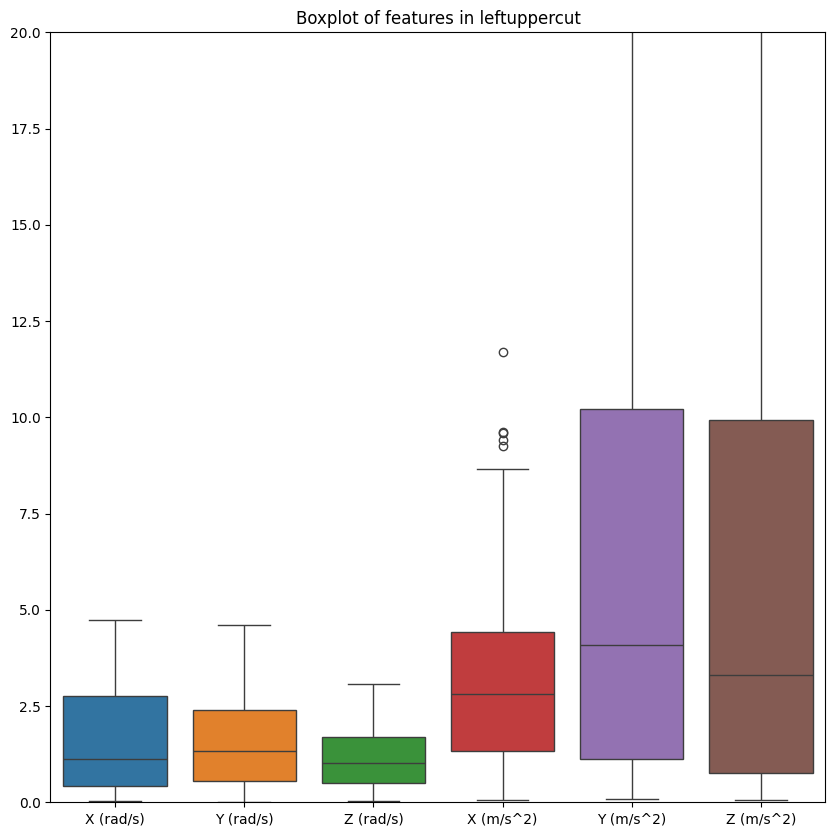

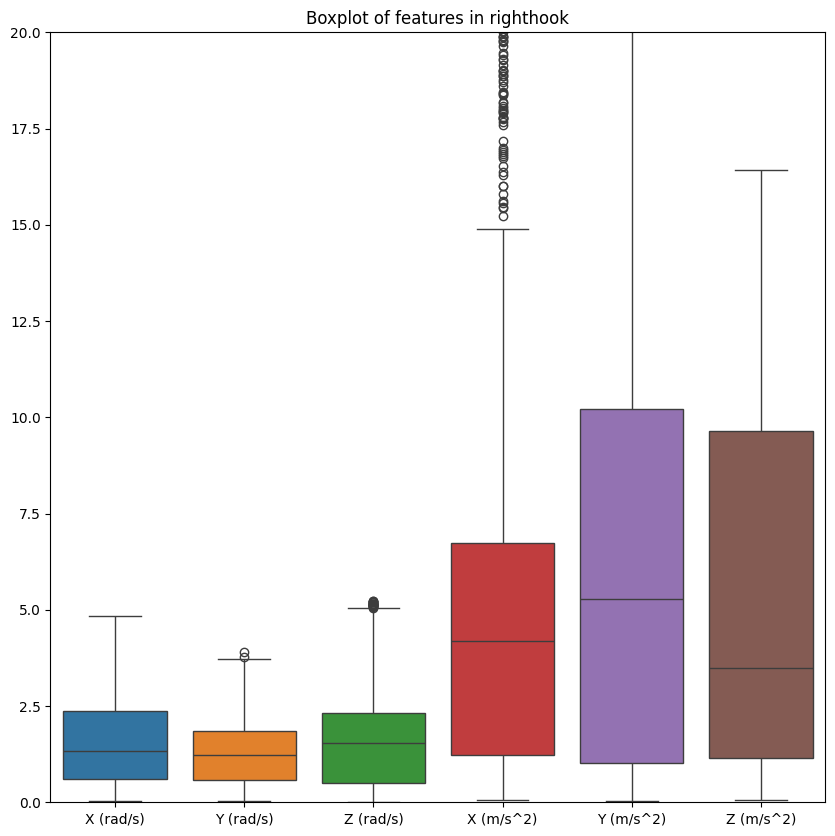

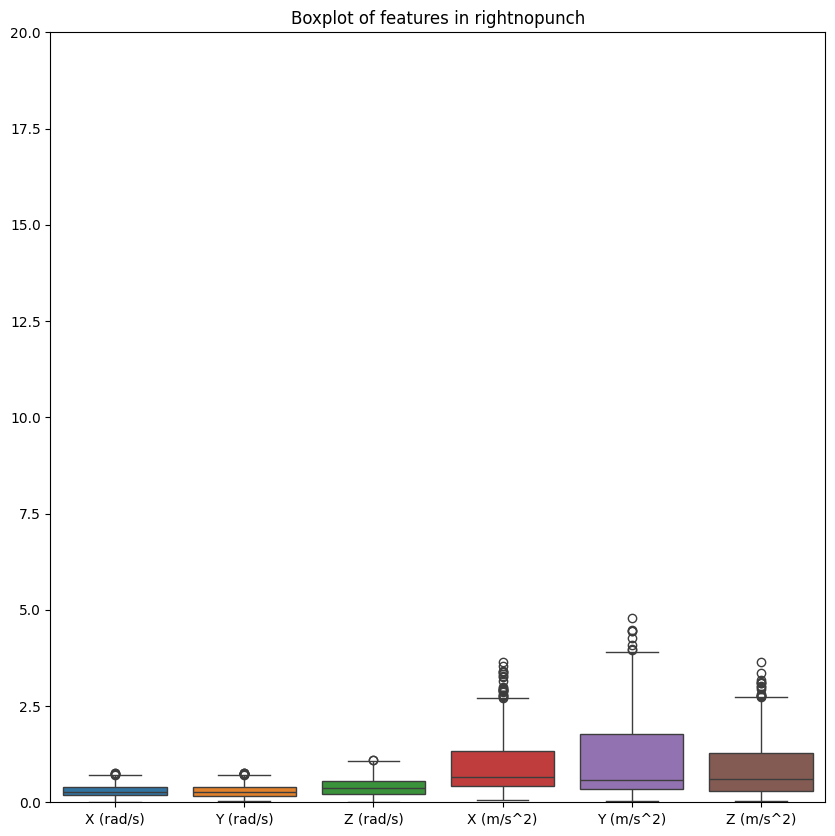

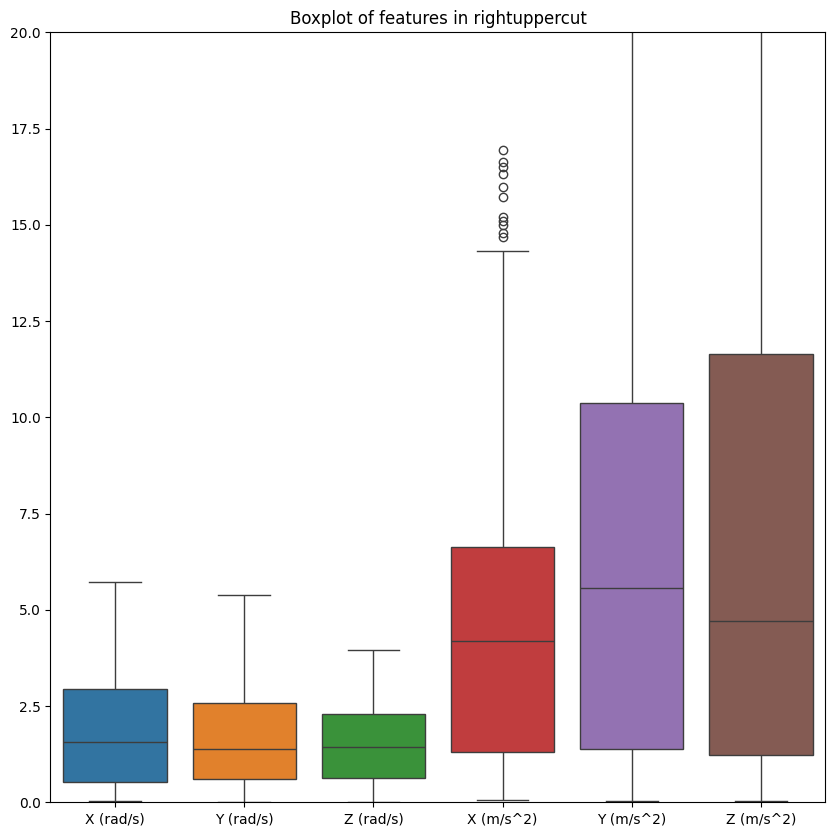

In [19]:
# Let's have a look at how it looks now!

# Some new outliers were created indeed after the removal. But comparing to the previous one, it looks much much cleaner already!

for df_name, df_content in dict_transformed_50_clean.items():
    boxplot_feature(df_content, df_name, show_dist=False)

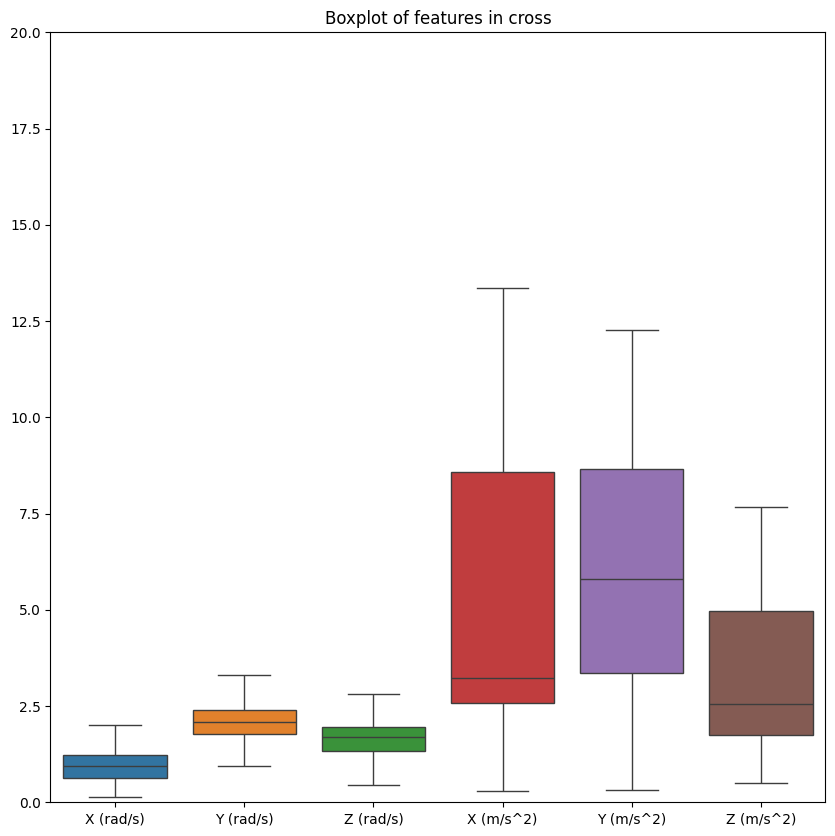

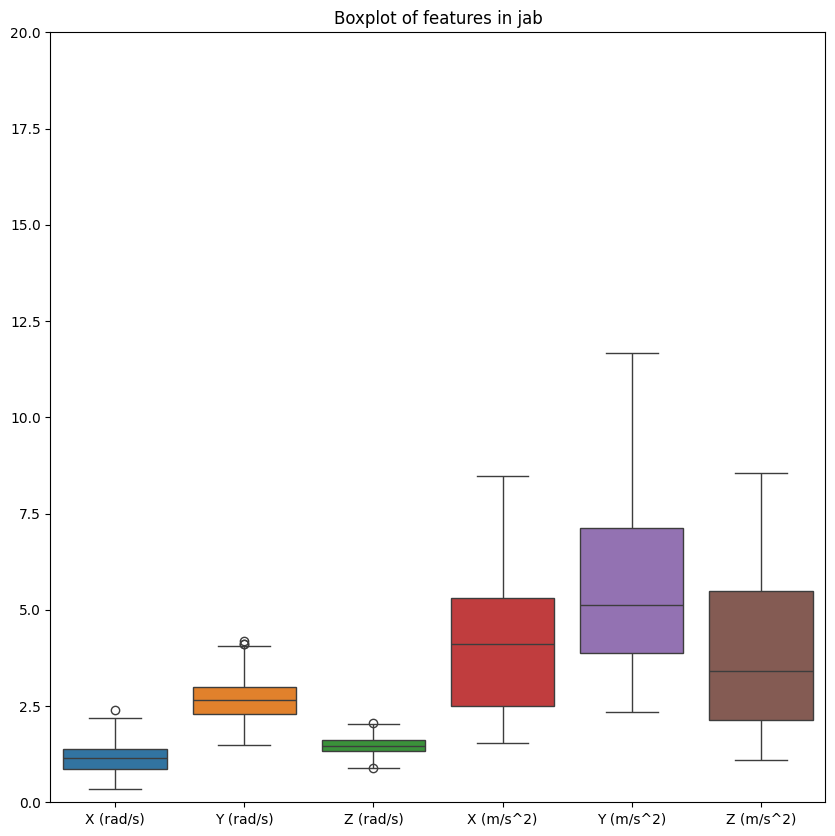

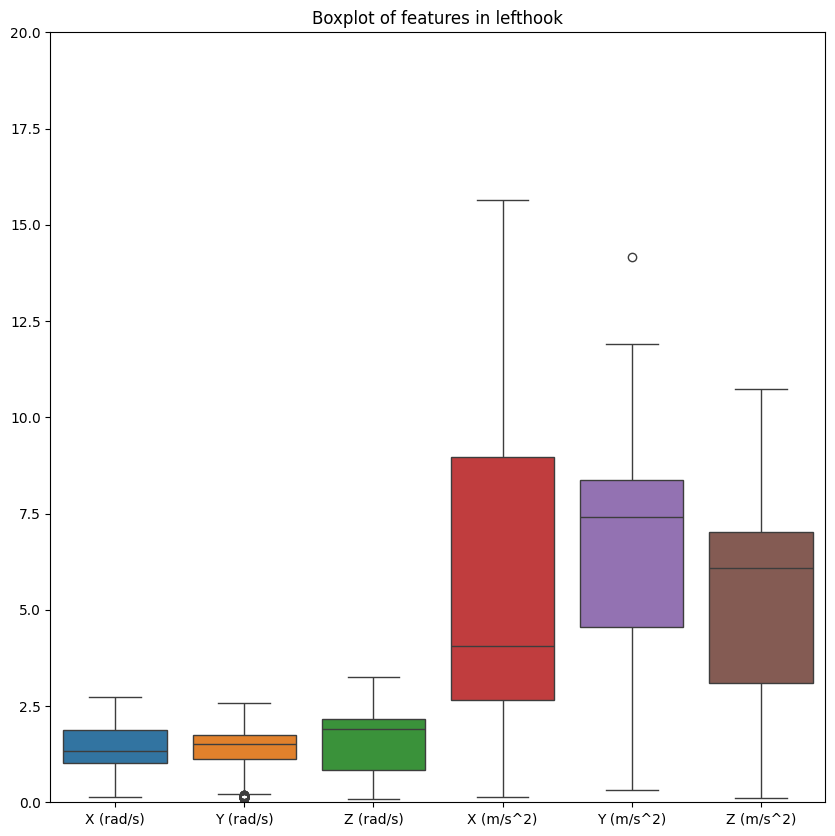

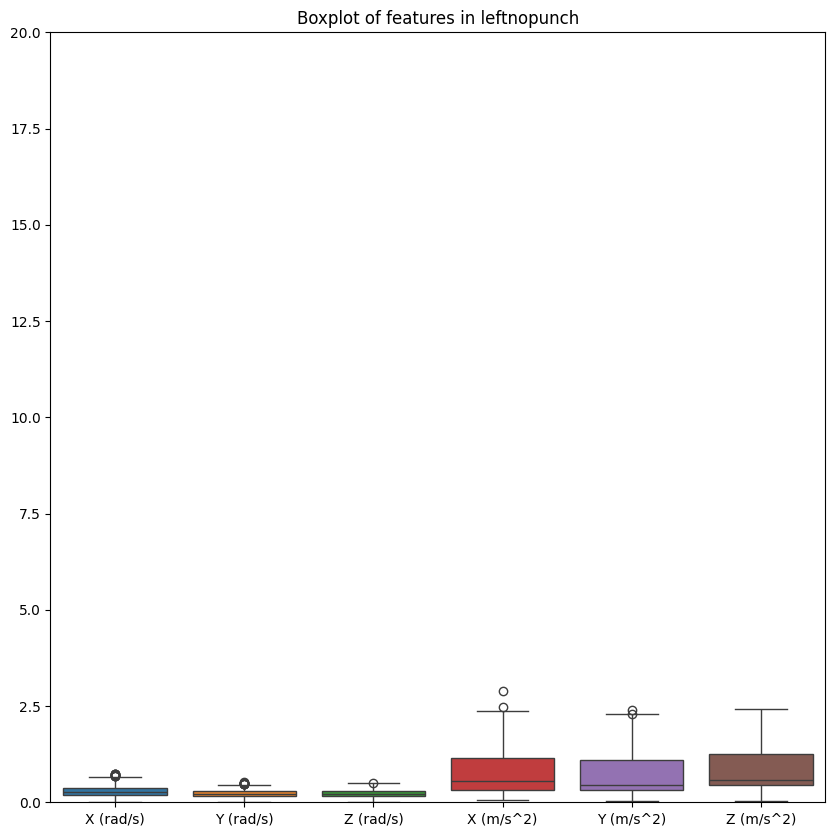

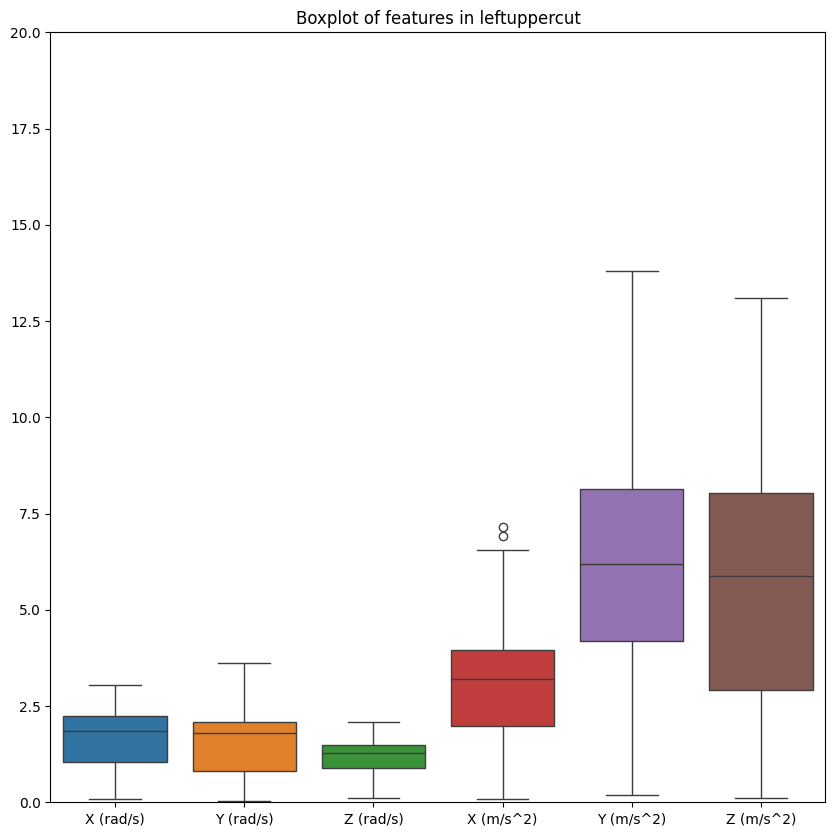

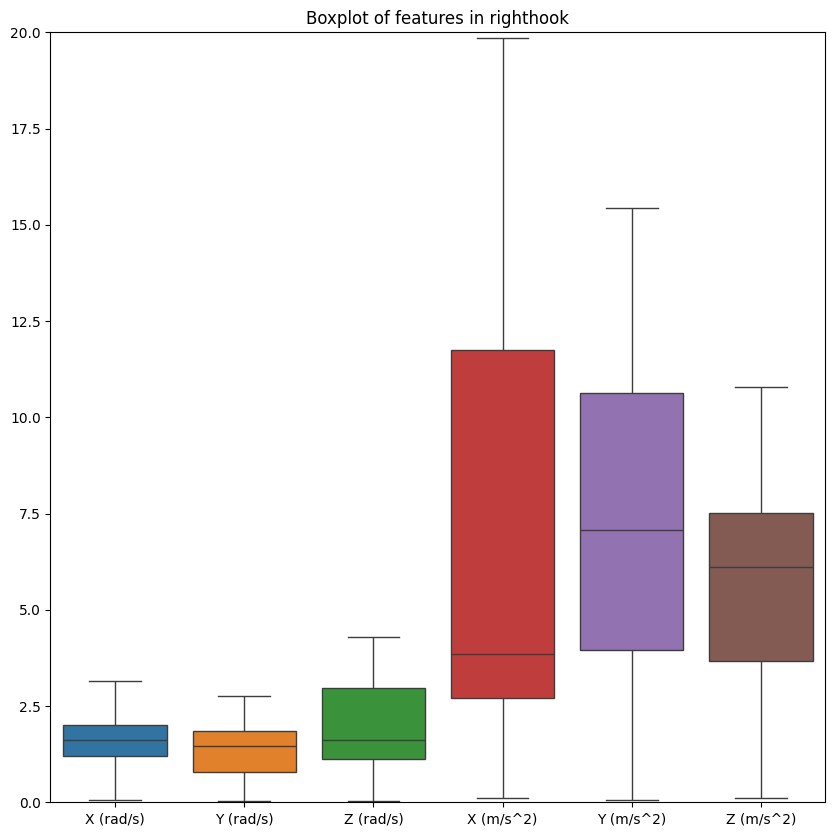

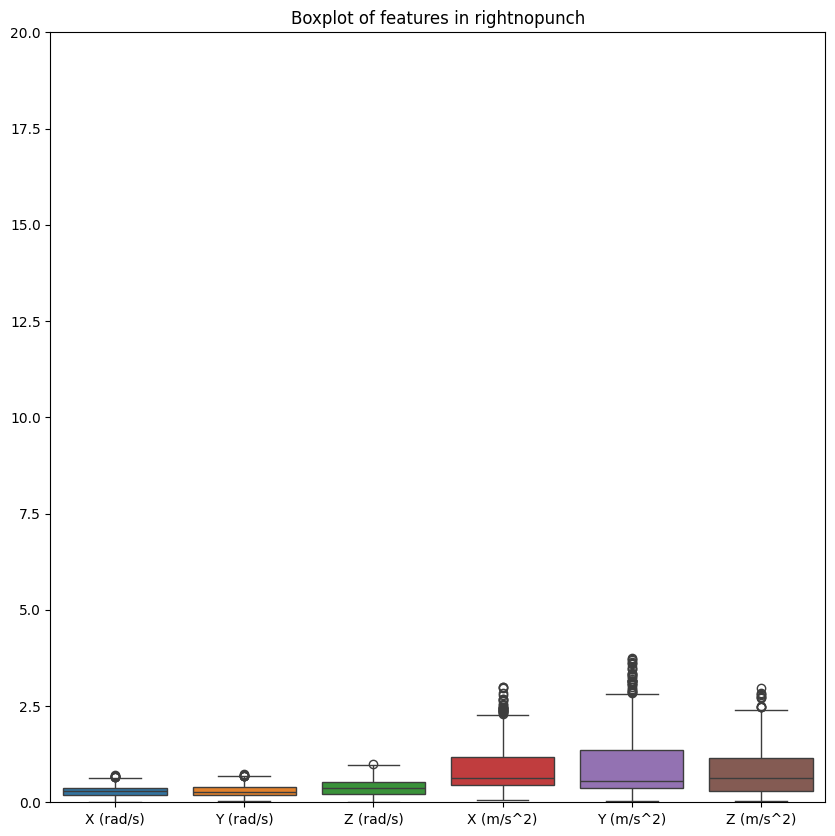

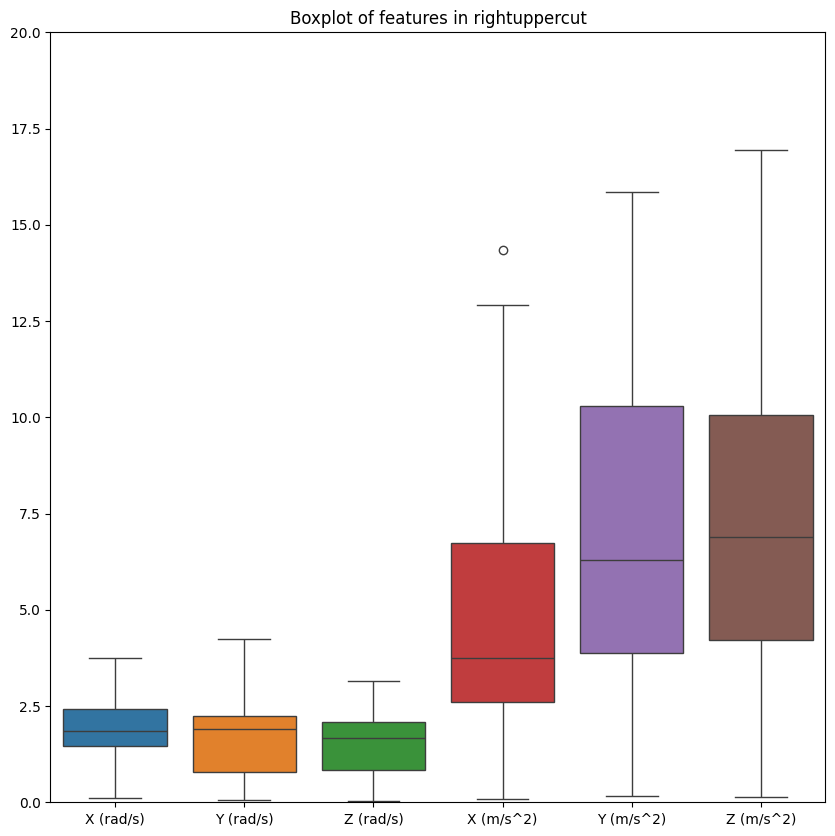

In [20]:
for df_name, df_content in dict_transformed_100_clean.items():
    boxplot_feature(df_content, df_name)

In [21]:
# Convert the clean data into a complete dataset and shuffle it
# Can be done with train_test_split as well, but I did iy myself anyway

df_clean_window50 = pd.concat([df_content for df_content in dict_transformed_50_clean.values()], axis = 0)
df_clean_window100 = pd.concat([df_content for df_content in dict_transformed_100_clean.values()], axis = 0)

df_clean_window50 = df_clean_window50.sample(frac=1).reset_index(drop=True)
df_clean_window100 = df_clean_window100.sample(frac=1).reset_index(drop=True)

df_clean_window100

,X (rad/s),Y (rad/s),Z (rad/s),X (m/s^2),Y (m/s^2),Z (m/s^2),Punch Type
0,2.129,1.571,1.571,4.685,6.801,6.773,righthook
1,1.439,2.266,3.634,14.083,12.936,7.454,righthook
2,1.850,1.656,2.385,9.950,9.321,7.437,lefthook
3,0.816,2.716,1.559,5.319,7.073,4.558,jab
4,0.208,0.197,0.271,1.189,1.424,0.365,rightnopunch
...,...,...,...,...,...,...,...
3637,1.709,1.876,3.439,11.432,11.263,7.483,righthook
3638,0.055,0.051,0.128,0.291,0.178,0.131,rightnopunch
3639,0.653,2.670,1.076,3.588,3.173,2.307,jab
3640,1.174,2.312,1.808,7.215,8.524,4.594,cross


In [22]:
# # # One-hot encode the labels
# # # Also print their original and encoded values out to check which one is encoded to what later.

# label_encoder = OneHotEncoder(sparse_output=False)

# labels_50 = df_clean_window50.iloc[:,-1]
# labels_100 = df_clean_window100.iloc[:,-1]

# print(f"Original labels of 50 window: \n{labels_50[:50]}")
# labels_50 = label_encoder.fit_transform(labels_50.values.reshape(-1,1))
# print(f"Encoded labels of 50 window: \n{labels_50[:50]}")
# print(" ")

# print(f"Original labels of 100 window: \n{labels_100[:50]}")
# labels_100 = label_encoder.fit_transform(labels_100.values.reshape(-1,1))
# print(f"Encoded labels of 100 window: \n{labels_100[:50]}")

In [23]:
# Train-test-split
x_train_50, x_test_50, y_train_50, y_test_50 = train_test_split(df_clean_window50.iloc[:,:-1],df_clean_window50.iloc[:,-1], 
                            test_size=0.3, random_state=50)
x_train_100, x_test_100, y_train_100, y_test_100 = train_test_split(df_clean_window100.iloc[:,:-1],df_clean_window100.iloc[:,-1],
                            test_size=0.3, random_state=50)

In [24]:
# To ensure the quality of training and to avoid bias, carefully check if there exists data leakage
# Data leakage happens when training and test dataset have same elements.
# The follwoing function will return False if there is no data leakage.

def check_data_leakage(df_train, df_test, show_leaked_data = False):

    set_train = set()
    set_test = set()
    datatype = type(df_train)
    
    for i in range(len(df_train)):
        
        if datatype == np.ndarray:
            set_train.add(tuple(df_train[i]))

        else:
            set_train.add(tuple(df_train.iloc[i,:]))

    for j in range(len(df_test)):
        
        if datatype == np.ndarray:
            set_test.add(tuple(df_test[j]))

        else:
            set_test.add(tuple(df_test.iloc[j,:]))

    leaked_data = set_train.intersection(set_test)

    if len(leaked_data) == 0:
        print("No data leakage!")
        return False

    else:
        print("Data leaked!")

        if show_leaked_data:
            print(leaked_data)

        return True

In [25]:
check_data_leakage(x_train_50, x_train_50)
check_data_leakage(x_train_100, x_test_100)

Data leaked!
No data leakage!


False

In [26]:
# Standardize the training data
scaler = MinMaxScaler()

x_train_50 = scaler.fit_transform(x_train_50)
x_train_100 = scaler.fit_transform(x_train_100)

x_test_50 = scaler.transform(x_test_50)
x_test_100 = scaler.transform(x_test_100)

In [27]:
check_data_leakage(x_train_50, x_train_50)
check_data_leakage(x_train_100, x_test_100)

Data leaked!
No data leakage!


False

# Model training and classification report

### Window of 50

In [28]:
k = 8
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(x_train_50, y_train_50)

y_pred = knn.predict(x_test_50)

print("Confusion Matrix:")
print(confusion_matrix(y_test_50, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_50, y_pred))

Confusion Matrix:
[[158  89  23   9   1  26   4   4]
 [ 34 268  15  11   8   5   2   3]
 [ 19  37  84   4  41  72   4  33]
 [  6  35   9 136   1  19  20   2]
 [ 13  29  33   1  97  13   3  67]
 [ 29  12  33   9  24 107   1  58]
 [ 22  21  28  32  17  17 112   3]
 [ 32  24  19   4  26  33   1 144]]

Classification Report:
               precision    recall  f1-score   support

        cross       0.50      0.50      0.50       314
          jab       0.52      0.77      0.62       346
     lefthook       0.34      0.29      0.31       294
  leftnopunch       0.66      0.60      0.63       228
 leftuppercut       0.45      0.38      0.41       256
    righthook       0.37      0.39      0.38       273
 rightnopunch       0.76      0.44      0.56       252
rightuppercut       0.46      0.51      0.48       283

     accuracy                           0.49      2246
    macro avg       0.51      0.49      0.49      2246
 weighted avg       0.50      0.49      0.49      2246



In [29]:
# Compare with the dummy classifier

dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(x_train_50, y_train_50)

dummy_pred = dummy_clf.predict(x_test_50)

print("Confusion Matrix:")
print(confusion_matrix(y_test_50, dummy_pred))
print("\nClassification Report:")
print(classification_report(y_test_50, dummy_pred))

Confusion Matrix:
[[38 46 48 44 34 27 42 35]
 [50 41 38 46 34 51 35 51]
 [45 38 29 34 30 38 36 44]
 [30 25 32 24 25 34 33 25]
 [40 29 31 32 37 29 34 24]
 [39 34 36 32 37 29 44 22]
 [30 25 41 33 31 29 34 29]
 [27 32 36 46 35 42 29 36]]

Classification Report:
               precision    recall  f1-score   support

        cross       0.13      0.12      0.12       314
          jab       0.15      0.12      0.13       346
     lefthook       0.10      0.10      0.10       294
  leftnopunch       0.08      0.11      0.09       228
 leftuppercut       0.14      0.14      0.14       256
    righthook       0.10      0.11      0.11       273
 rightnopunch       0.12      0.13      0.13       252
rightuppercut       0.14      0.13      0.13       283

     accuracy                           0.12      2246
    macro avg       0.12      0.12      0.12      2246
 weighted avg       0.12      0.12      0.12      2246



#### Try different value of k
We will observe the difference of precision, recall and accuracy at different k, from 1 to 100

In [30]:
# Set up the variables to save precision, recall and accuracy at k
dict_precision_at_ks = dict()
dict_recall_at_ks = dict()
dict_f1_at_ks = dict()

accuracy_at_ks = []

for punch_type in y_train_50.unique():
    dict_precision_at_ks.setdefault(punch_type, [])
    dict_recall_at_ks.setdefault(punch_type, [])
    dict_f1_at_ks.setdefault(punch_type, [])

In [31]:
# classification report is a string. We will do some string formatting to retrieve and assign the value we need

def get_values_from_report(report, feature_name):
    """
    Get the precision, recall, and the accuracy of the given feature from the classification report
    """

    precision = 0
    recall = 0
    f1 = 0
    accuracy = 0

    # Split the report by lines
    report_l1 = report.strip().split("\n")
    
    # Remove the first two lines (header information)
    report_l1 = report_l1[2:]

    # Process each line to split by whitespace
    report_l2 = [line.strip().split() for line in report_l1 if line.strip()]

    for line in report_l2:
        if len(line) > 1 and line[0] == feature_name:
            # Extract the scores for the given feature
            precision = float(line[1].strip())
            recall = float(line[2].strip())
            f1 = float(line[3].strip())
        if 'accuracy' in line:
            # Extract the accuracy value
            accuracy_idx = line.index('accuracy') + 1
            try:
                accuracy = float(line[accuracy_idx].strip())
            except ValueError:
                accuracy = 0  # Default to 0 if conversion fails

    return precision, recall, f1, accuracy


In [32]:
# Model train and evaluation at an arbiatry k
def knn_model_pred(k, x_train, y_train, x_test, y_test, returns_report = False, print_results = False):
    
    """
    Trains a knn model at a given k, and makes predictions.
    Assume data have already been preprocessed. 

    Optional (False by default):
    - Returns a classification report if returns_report = True. 
    - Prints the evaluation results if print_results = True.
    """

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(x_train, y_train)
    
    y_pred = knn.predict(x_test)

    print(f"training at {k} neighbors complete!")

    if print_results:
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    if returns_report:
        return classification_report(y_test, y_pred)

In [33]:
for k in range(1,101):
    report = knn_model_pred(k, x_train_50, y_train_50, x_test_50, y_test_50, returns_report=True)
    
    accuracy_at_k = 0
    for feature_name in y_train_50.unique():
        precision, recall, f1, accuracy = get_values_from_report(report, feature_name)

        dict_precision_at_ks[feature_name].append(precision)
        dict_recall_at_ks[feature_name].append(recall)
        dict_f1_at_ks[feature_name].append(f1)

        accuracy_at_k = accuracy

    accuracy_at_ks.append(accuracy_at_k)

training at 1 neighbors complete!
training at 2 neighbors complete!
training at 3 neighbors complete!
training at 4 neighbors complete!
training at 5 neighbors complete!
training at 6 neighbors complete!
training at 7 neighbors complete!
training at 8 neighbors complete!
training at 9 neighbors complete!
training at 10 neighbors complete!
training at 11 neighbors complete!
training at 12 neighbors complete!
training at 13 neighbors complete!
training at 14 neighbors complete!
training at 15 neighbors complete!
training at 16 neighbors complete!
training at 17 neighbors complete!
training at 18 neighbors complete!
training at 19 neighbors complete!
training at 20 neighbors complete!
training at 21 neighbors complete!
training at 22 neighbors complete!
training at 23 neighbors complete!
training at 24 neighbors complete!
training at 25 neighbors complete!
training at 26 neighbors complete!
training at 27 neighbors complete!
training at 28 neighbors complete!
training at 29 neighbors comp

plot the result

In [34]:
def plot_metrics_at_ks(metrics, data, savefig=False):

    if metrics == 'Accuracy':
        accuracy_x = list(range(1,101))
        plt.plot(accuracy_x, data)
        
        plt.xlabel("k-neighbor")
        plt.ylabel("accuracy")
        plt.title("Overall accuracy at ks")
    
        if savefig:
            plt.savefig("Figures/Curve_accuracy_at_ks.png")
            
        plt.show()

    else:
        plt.figure(figsize=(12,10))
    
        sns.lineplot(data)
        
        plt.xlabel("k-neighbour")
        plt.ylabel(f'{metrics}')
        plt.title(f"{metrics} of punch types at ks")

        if savefig:
            plt.savefig(f"Figures/Curve_{metrics}_at_ks.png")
            
        plt.show()

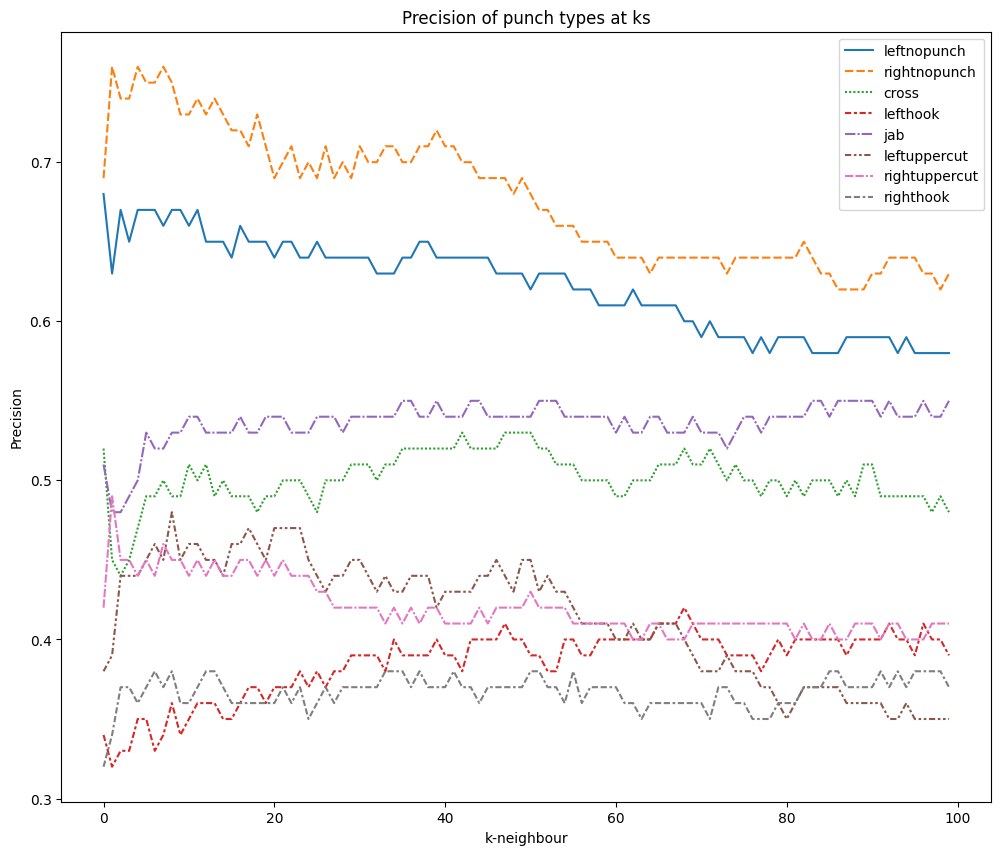

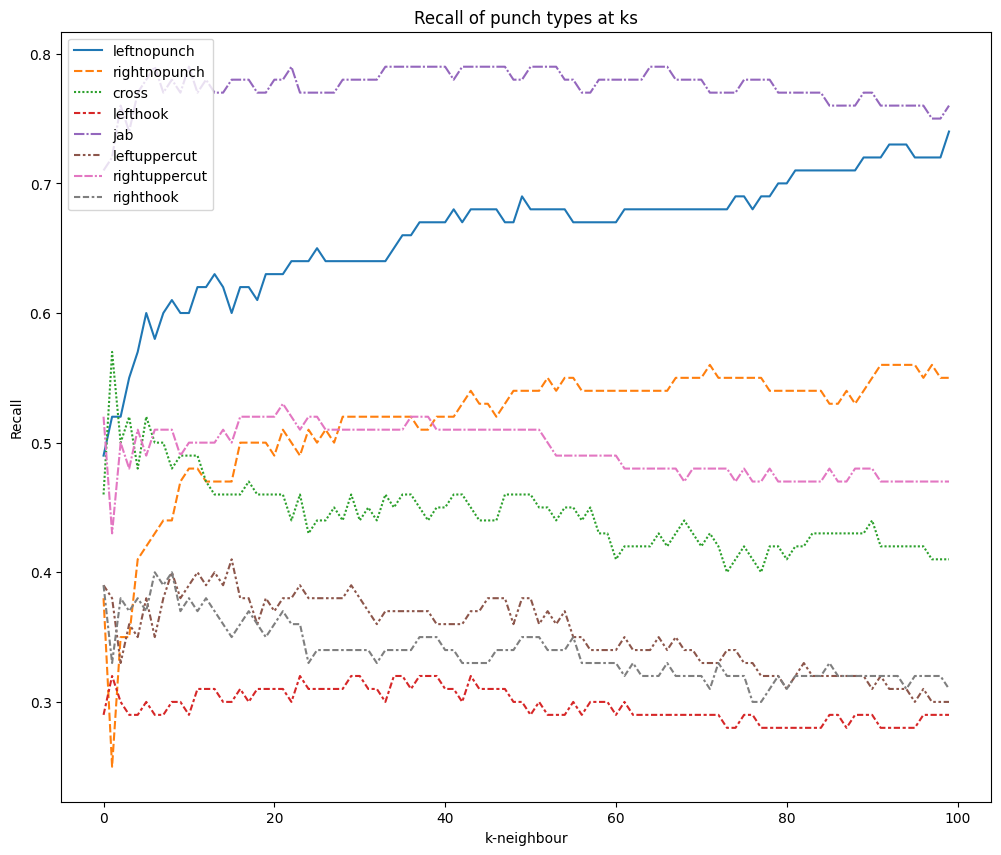

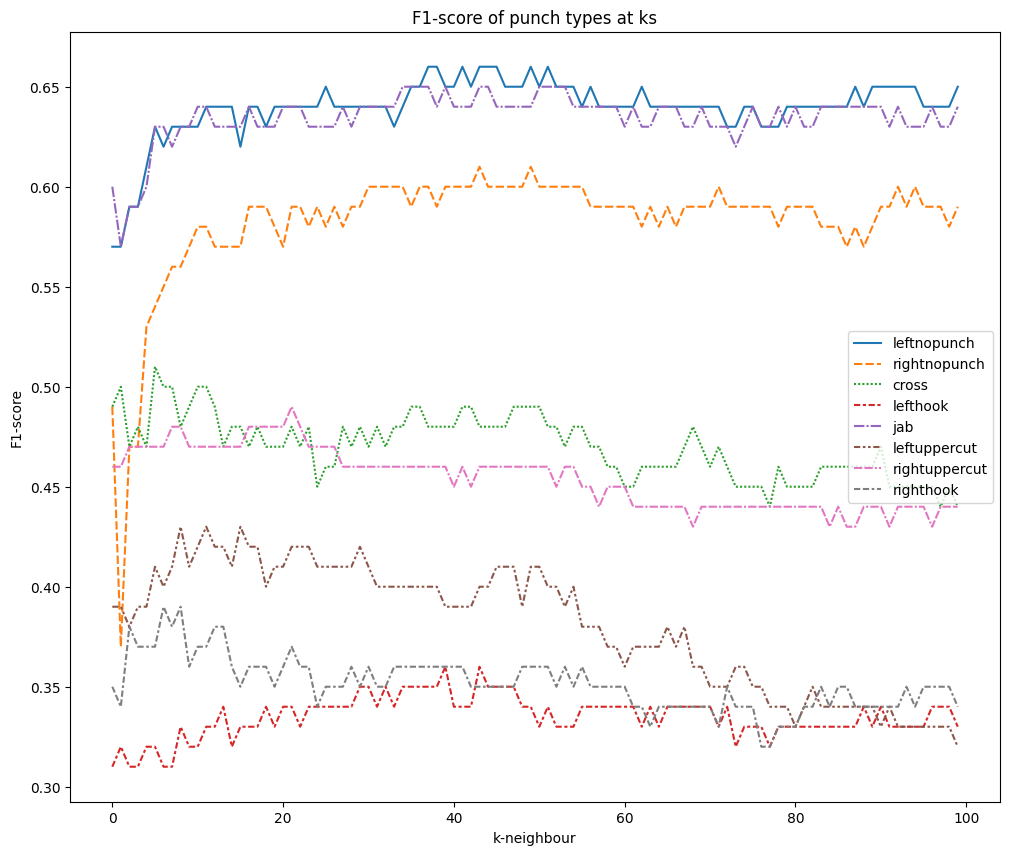

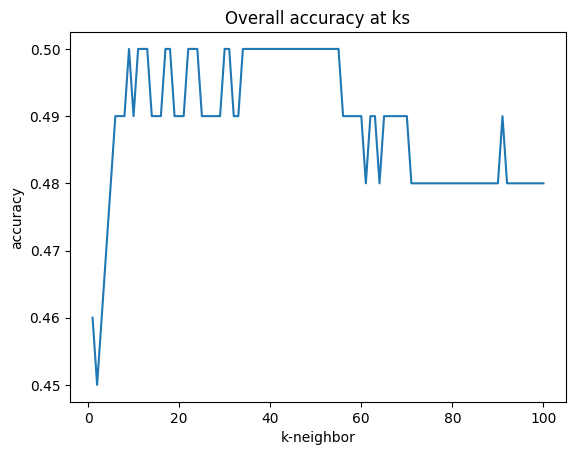

In [35]:
dict_precision_at_ks = pd.DataFrame(dict_precision_at_ks)
dict_recall_at_ks = pd.DataFrame(dict_recall_at_ks)
dict_f1_at_ks = pd.DataFrame(dict_f1_at_ks)

plot_metrics_at_ks("Precision", dict_precision_at_ks, savefig=True)
plot_metrics_at_ks("Recall", dict_recall_at_ks, savefig=True)
plot_metrics_at_ks("F1-score", dict_f1_at_ks, savefig=True)
plot_metrics_at_ks("Accuracy", accuracy_at_ks, savefig=True)

### Window of 100

In [36]:
k = 8
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(x_train_100, y_train_100)

y_pred = knn.predict(x_test_100)

print("Confusion Matrix:")
print(confusion_matrix(y_test_100, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_100, y_pred))

Confusion Matrix:
[[127   3   0   0   0   0   0   0]
 [  4 133   0   0   1   0   0   0]
 [  7   0 140   2   6   9   2   2]
 [  0   0   0 111   0   2  11   2]
 [  3   2  10   3 108   9  10   2]
 [  0   0   6   8   4  96   3   4]
 [  0   0   3  11   0   0 117   0]
 [  0   0  10   2   4   6   3 107]]

Classification Report:
               precision    recall  f1-score   support

        cross       0.90      0.98      0.94       130
          jab       0.96      0.96      0.96       138
     lefthook       0.83      0.83      0.83       168
  leftnopunch       0.81      0.88      0.84       126
 leftuppercut       0.88      0.73      0.80       147
    righthook       0.79      0.79      0.79       121
 rightnopunch       0.80      0.89      0.84       131
rightuppercut       0.91      0.81      0.86       132

     accuracy                           0.86      1093
    macro avg       0.86      0.86      0.86      1093
 weighted avg       0.86      0.86      0.86      1093



In [37]:
# Compare with the dummy classifier

dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(x_train_100, y_train_100)

dummy_pred = dummy_clf.predict(x_test_100)

print("Confusion Matrix:")
print(confusion_matrix(y_test_100, dummy_pred))
print("\nClassification Report:")
print(classification_report(y_test_100, dummy_pred))

Confusion Matrix:
[[14 15 19 23 12 11 14 22]
 [16 11 23 23 13 19 18 15]
 [16 23 21 14 32 19 29 14]
 [13 13 19 24  8 11 15 23]
 [16 20 17 21 20 12 23 18]
 [10 14 18 18 20 10 19 12]
 [17 12 14 19 21 13 17 18]
 [15 25 10 15 13 22 17 15]]

Classification Report:
               precision    recall  f1-score   support

        cross       0.12      0.11      0.11       130
          jab       0.08      0.08      0.08       138
     lefthook       0.15      0.12      0.14       168
  leftnopunch       0.15      0.19      0.17       126
 leftuppercut       0.14      0.14      0.14       147
    righthook       0.09      0.08      0.08       121
 rightnopunch       0.11      0.13      0.12       131
rightuppercut       0.11      0.11      0.11       132

     accuracy                           0.12      1093
    macro avg       0.12      0.12      0.12      1093
 weighted avg       0.12      0.12      0.12      1093



#### Try different value of k
We will observe the difference of precision, recall and accuracy at different k, from 1 to 100

In [38]:
# Set up the variables to save precision, recall and accuracy at k
dict_precision_at_ks = dict()
dict_recall_at_ks = dict()
dict_f1_at_ks = dict()

accuracy_at_ks = []

for punch_type in y_train_100.unique():
    dict_precision_at_ks.setdefault(punch_type, [])
    dict_recall_at_ks.setdefault(punch_type, [])
    dict_f1_at_ks.setdefault(punch_type, [])

In [39]:
for k in range(1,101):
    report = knn_model_pred(k, x_train_100, y_train_100, x_test_100, y_test_100, returns_report=True)
    
    accuracy_at_k = 0
    for feature_name in y_train_50.unique():
        precision, recall, f1, accuracy = get_values_from_report(report, feature_name)

        dict_precision_at_ks[feature_name].append(precision)
        dict_recall_at_ks[feature_name].append(recall)
        dict_f1_at_ks[feature_name].append(f1)

        accuracy_at_k = accuracy

    accuracy_at_ks.append(accuracy_at_k)

training at 1 neighbors complete!
training at 2 neighbors complete!
training at 3 neighbors complete!
training at 4 neighbors complete!
training at 5 neighbors complete!
training at 6 neighbors complete!
training at 7 neighbors complete!
training at 8 neighbors complete!
training at 9 neighbors complete!
training at 10 neighbors complete!
training at 11 neighbors complete!
training at 12 neighbors complete!
training at 13 neighbors complete!
training at 14 neighbors complete!
training at 15 neighbors complete!
training at 16 neighbors complete!
training at 17 neighbors complete!
training at 18 neighbors complete!
training at 19 neighbors complete!
training at 20 neighbors complete!
training at 21 neighbors complete!
training at 22 neighbors complete!
training at 23 neighbors complete!
training at 24 neighbors complete!
training at 25 neighbors complete!
training at 26 neighbors complete!
training at 27 neighbors complete!
training at 28 neighbors complete!
training at 29 neighbors comp

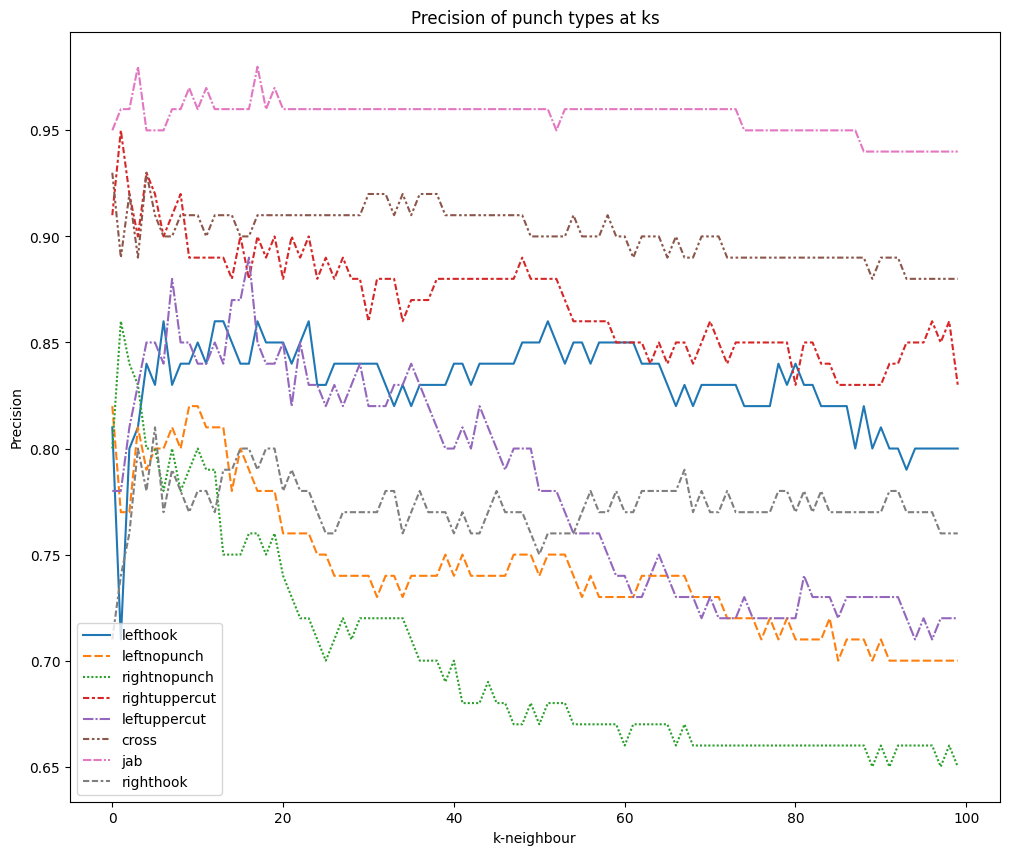

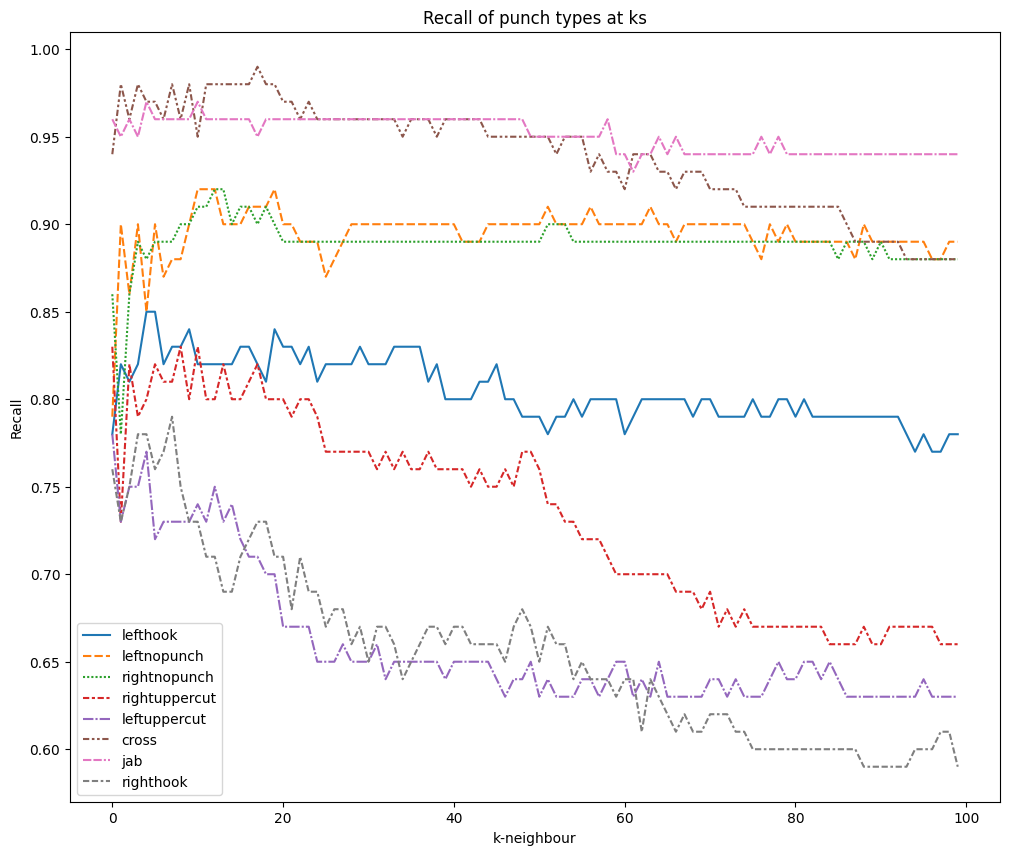

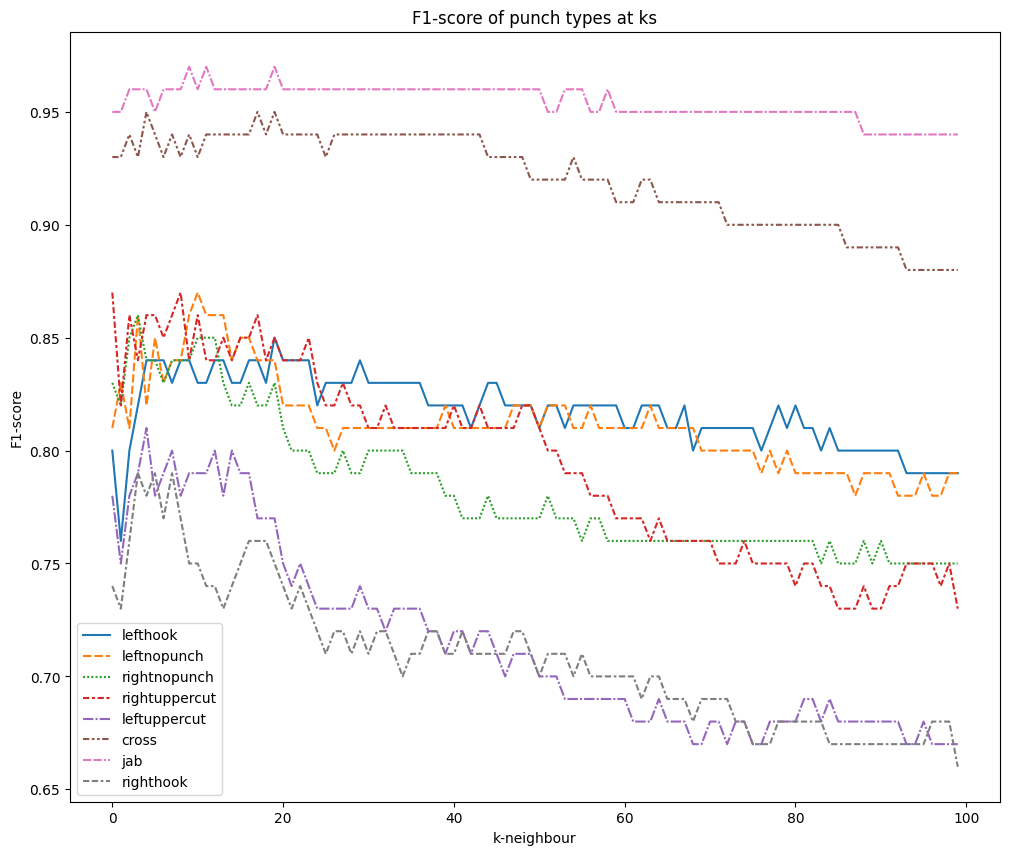

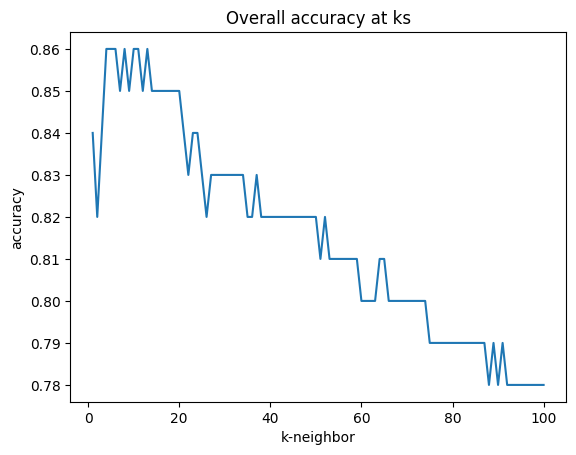

In [40]:
dict_precision_at_ks = pd.DataFrame(dict_precision_at_ks)
dict_recall_at_ks = pd.DataFrame(dict_recall_at_ks)
dict_f1_at_ks = pd.DataFrame(dict_f1_at_ks)

plot_metrics_at_ks("Precision", dict_precision_at_ks, savefig=True)
plot_metrics_at_ks("Recall", dict_recall_at_ks, savefig=True)
plot_metrics_at_ks("F1-score", dict_f1_at_ks, savefig=True)
plot_metrics_at_ks("Accuracy", accuracy_at_ks, savefig=True)